### Introduction
Over the past few years, there has been a resurgence in vaccine-preventable diseases observed in children aged 19 through 35 months in the US, despite the availability of free routine immunizations. Eradicated or nearly eradicated diseases like measles and pertussis are on the rise in the country, which is mostly due to parents that choose not to vaccinate their children, decision that is often influenced by misinformation spread online through social media platforms. Vaccination, and especially children vaccination has been around for some time now and has been proven to be safe and effective. Therefore, unvaccinated children put at risk the lives of other people who cannot be vaccinated because of weak immune systems or other reasons. Some vaccine-preventable diseases can cause life-long consequences such as prolonged disabilities, put a financial toll on family (medical bills, lost time at work, long-term disability care) and governments. 

What if we can use data to help identify children who are likely to default on their routine immunization schedule? What if we can narrow down the most important common factors shared by those families at greater risk of not getting their children vaccinated? Doing so could enable heatlh officials and physicians to talk with parents at the stage when they are still undecided about vaccines, stressing the importance of vaccinating their children. The reason this could be useful is that, while it’s very hard to persuade someone once they’ve made up their mind, it might be easier if we know early enough and approach them in a friendly manner. This study could also allow vaccinators and policy makers to put in place customized vaccination-promotion policies.

For this project, I want to use predictive algorithms to predict children who are likely to default on their routine immunization schedule. The data comes from the NIS (National Immunization Survey-Child (NIS-Child)) webpage https://www.cdc.gov/vaccines/imz-managers/nis/datasets.html. It should be noted that the data runs from 1995 to 2019 with hundreds of variables. However, only data from 2016 to 2019 are used to reduce processing time, and  23 variables to avoid target leakage. The features are summarized in the following table:

| Feature | Description   |
|------|------|
|  SEQNUMC and SEQNUMHH  | ID codes for children and their household. |
|  PDAT  |  Flag for children with adequate (health) provider data.  |
|  YEAR  |  Year during which the data were collected in the format YYYY.  |
|  STATE  |  State of residence of child.  |
|  AGEGRP and RACEETHK  |  Age category (months) and race/ethnicity of the child.  |
|  FRSTBRN and CBF_01  |  Is child first born and was child ever breastfed.  |
|  BF_ENDR06  |  Duration of breastfeeding in days.  |
|  CWIC_01 and INS_STAT2_I  |  Has child ever received WIC benefits and child insurance status.  |
|  CHILDNM and C1R   |  Number of children (< 18 years old) and number of people in household.  |
|  M_AGEGRP2 and MARITAL2  |  Mother age group and marital status.  |
|  EDUC1  |  Education level of mother.  |
|  INCPORAR_I  | Income to poverty ratio.  |
|  LANGUAGE  |  Language in whic interview was conducted.  |
|  RENT_OWN  |  Home ownership status.  |
|  PROV_FAC  |  Types of provider facility.  |
|  N_PRVR  |  Number of providers responding with vaccination data for child.  |
|  PU4313313  |  Target variable: vaccination status (up-to-date (UTD) or not flag for provider).  |

The vaccine in question here is a combination vaccine series: 4+ DT-containing (03,04,07,08,D3), 3+ Polio-containing (08,20,21,22,D3), 1+ Measles-containing (30,31,32,33,MM,VM), HIB (routine, strict definition, 3-4 doses of influenza vaccine), 3+ Hepatitis B-containing (08,43,60,HB), 1+ Varicella-containing (VO,VM,VA) at age 12+ months, and 4+ Pneumococcal-containing (70,71,72,73,74).

This notebook addresses 3 different questions:
1. What are the socio-economic and demographic characteristics of children not up-to-date with their vaccines?
2. Which states have the highest percentages of unvaccinated children?

After, I will split the data into training sets (years 2016-2018) and use several classification models to predict children defaulting on their vaccine schedule (year 2019).



In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn import ensemble
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from statsmodels.stats.proportion import proportion_confint # Import this library for 95% CI
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
%matplotlib inline

import warnings

# warnings.filterwarnings('ignore')
# warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1 - Importing the data
The data for each year comes in a DAT file with all variables lumped into one column. I therefore have to import each variable based on its byte location provided in the data description pdf file for each year (https://www.cdc.gov/vaccines/imz-managers/nis/datasets.html).

In [2]:
# Load the data
immunization_df_16 = pd.read_csv("https://ftp.cdc.gov/pub/Vaccines_NIS/NISPUF16.DAT", header= None)
immunization_df_17 = pd.read_csv("https://ftp.cdc.gov/pub/Vaccines_NIS/NISPUF17.DAT", header= None)
immunization_df_18 = pd.read_csv("https://ftp.cdc.gov/pub/Vaccines_NIS/NISPUF18.DAT", header= None)
immunization_df_19 = pd.read_csv("https://ftp.cdc.gov/pub/Vaccines_NIS/NISPUF19.DAT", header= None)


In [3]:
# Information on the data
print(immunization_df_16.info())
print(immunization_df_16.head())
print()
print(immunization_df_17.info())
print(immunization_df_17.head())
print()
print(immunization_df_18.info())
print(immunization_df_18.head())
print()
print(immunization_df_19.info())
immunization_df_19.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28296 entries, 0 to 28295
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       28296 non-null  object
dtypes: object(1)
memory usage: 221.2+ KB
None
                                                   0
0  127951127952     .                   .        ...
1  010611010611 1146.68007967196000 1146.68007967...
2  218931218932     .                   .        ...
3  085831085832     .                   .        ...
4  226001226001  127.90460468239400  127.90460468...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28465 entries, 0 to 28464
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       28465 non-null  object
dtypes: object(1)
memory usage: 222.5+ KB
None
                                                   0
0  128521128522     .               235.916956155...
1  010741010742     .               957.353840327

,0
0,152651152651 503.79361943176100 503.79361943...
1,012631012632 . . ...
2,261061261061 66.14718761920970 66.14718761...
3,102261102262 . . ...
4,269631269632 . . ...


In [4]:
# CDC 2016 
%%time
for i in range(0, len(immunization_df_16[0].values)):
  # ID variables
  immunization_df_16.loc[i, 'SEQNUMC'] = immunization_df_16[0].values[i][:6] 
  immunization_df_16.loc[i, 'SEQNUMHH'] = immunization_df_16[0].values[i][6:11]
  immunization_df_16.loc[i, 'PDAT'] = immunization_df_16[0].values[i][11]

  immunization_df_16.loc[i, 'YEAR'] = immunization_df_16[0].values[i][94:98]
  immunization_df_16.loc[i, 'AGEGRP'] = immunization_df_16[0].values[i][101]
  immunization_df_16.loc[i, 'BF_ENDR06'] = immunization_df_16[0].values[i][102:110] 
  immunization_df_16.loc[i, 'C1R'] = immunization_df_16[0].values[i][128]
  immunization_df_16.loc[i, 'CBF_01'] = immunization_df_16[0].values[i][131:133]
 
  immunization_df_16.loc[i, 'CHILDNM'] = immunization_df_16[0].values[i][134]
  immunization_df_16.loc[i, 'CWIC_01'] = immunization_df_16[0].values[i][135:137]
  immunization_df_16.loc[i, 'EDUC1'] = immunization_df_16[0].values[i][139]
  immunization_df_16.loc[i, 'FRSTBRN'] = immunization_df_16[0].values[i][140]
  immunization_df_16.loc[i, 'INCPORAR_I'] = immunization_df_16[0].values[i][158:174]
 
  immunization_df_16.loc[i, 'LANGUAGE'] = immunization_df_16[0].values[i][177]
  immunization_df_16.loc[i, 'M_AGEGRP2'] = immunization_df_16[0].values[i][178]
  immunization_df_16.loc[i, 'MARITAL2'] = immunization_df_16[0].values[i][179]
  immunization_df_16.loc[i, 'RACEETHK'] = immunization_df_16[0].values[i][188]
  immunization_df_16.loc[i, 'RENT_OWN'] = immunization_df_16[0].values[i][189:191]

  immunization_df_16.loc[i, 'STATE'] = immunization_df_16[0].values[i][197:199]
  immunization_df_16.loc[i, 'N_PRVR'] = immunization_df_16[0].values[i][201]
  immunization_df_16.loc[i, 'PROV_FAC'] = immunization_df_16[0].values[i][202]
  immunization_df_16.loc[i, 'INS_STAT2_I'] = immunization_df_16[0].values[i][863]

  # Target variable. Combination vaccine series, target variable, provider-reported doses of vaccine variables
  immunization_df_16.loc[i, 'PU4313313'] = immunization_df_16[0].values[i][280] 
 


CPU times: user 1min 30s, sys: 456 ms, total: 1min 31s
Wall time: 1min 30s


In [5]:
# CDC 2017.  
%%time
for i in range(0, len(immunization_df_17[0].values)):
  # ID variables
  immunization_df_17.loc[i, 'SEQNUMC'] = immunization_df_17[0].values[i][:6] # Unique child identifier
  immunization_df_17.loc[i, 'SEQNUMHH'] = immunization_df_17[0].values[i][6:11] # Unique household identifier
  immunization_df_17.loc[i, 'PDAT'] = immunization_df_17[0].values[i][11] # Child has adequate (health) provider data

  immunization_df_17.loc[i, 'YEAR'] = immunization_df_17[0].values[i][55:59] # Year of interview.
  immunization_df_17.loc[i, 'AGEGRP'] = immunization_df_17[0].values[i][62] # Age category of child (19-23, 24-29, 30-35 MO).
  immunization_df_17.loc[i, 'BF_ENDR06'] = immunization_df_17[0].values[i][63:71] # Duration of breastfeeding in days.
  immunization_df_17.loc[i, 'C1R'] = immunization_df_17[0].values[i][89] # Number of people in household
  immunization_df_17.loc[i, 'CBF_01'] = immunization_df_17[0].values[i][92:94] # Was child ever breastfed or fed breast milk?
 
  immunization_df_17.loc[i, 'CHILDNM'] = immunization_df_17[0].values[i][95] # Number of children less than 18 years in household.
  immunization_df_17.loc[i, 'CWIC_01'] = immunization_df_17[0].values[i][96:98] # Child ever received WIC benefits?
  immunization_df_17.loc[i, 'EDUC1'] = immunization_df_17[0].values[i][100] # Education of mother categories.
  immunization_df_17.loc[i, 'FRSTBRN'] = immunization_df_17[0].values[i][101] # First born status of child.
  immunization_df_17.loc[i, 'INCPORAR_I'] = immunization_df_17[0].values[i][119:135] # Income to poverty ratio imputed.

  immunization_df_17.loc[i, 'LANGUAGE'] = immunization_df_17[0].values[i][138] # Language in which interview was conducted.
  immunization_df_17.loc[i, 'M_AGEGRP2'] = immunization_df_17[0].values[i][139] # Age of mother catgeories
  immunization_df_17.loc[i, 'MARITAL2'] = immunization_df_17[0].values[i][140] # Marital status of moher. 
  immunization_df_17.loc[i, 'RACEETHK'] = immunization_df_17[0].values[i][149] # Race/ethnicity of child.
  immunization_df_17.loc[i, 'RENT_OWN'] = immunization_df_17[0].values[i][150:152] # Is home owned/being bought, rented, or occupied by some other arrangement?

  immunization_df_17.loc[i, 'STATE'] = immunization_df_17[0].values[i][158:160] # True state of residence.
  immunization_df_17.loc[i, 'N_PRVR'] = immunization_df_17[0].values[i][162] # Number of providers responding with vaccination data for child.
  immunization_df_17.loc[i, 'PROV_FAC'] = immunization_df_17[0].values[i][163] # Provider facility types.
  immunization_df_17.loc[i, 'INS_STAT2_I'] = immunization_df_17[0].values[i][833] # Insurance status

  # Target variable: up-to-date (UTD) flag for provider, stating if child is UTD with vaccine or not.
  # Combination vaccine series, target variable, provider-reported doses of vaccine variables
  # 4+ DT-containing (03,04,07,08,D3), 3+ Polio-containing (08,20,21,22,D3), 1+ Measles-containing (30,31,32,33,MM,VM),
  # HIB (routine, strict definition, 3-4 doses of influenza vaccine), 3+ Hepatitis B-containing (08,43,60,HB), 
  # 1+ Varicella-containing (VO,VM,VA) at age 12+ months, and 4+ Pneumococcal-containing (70,71,72,73,74).
  immunization_df_17.loc[i, 'PU4313313'] = immunization_df_17[0].values[i][241] 



CPU times: user 1min 33s, sys: 962 ms, total: 1min 34s
Wall time: 1min 33s


In [6]:
# CDC 2018
%%time
for i in range(0, len(immunization_df_18[0].values)):
  # ID variables
  immunization_df_18.loc[i, 'SEQNUMC'] = immunization_df_18[0].values[i][:6] 
  immunization_df_18.loc[i, 'SEQNUMHH'] = immunization_df_18[0].values[i][6:11]
  immunization_df_18.loc[i, 'PDAT'] = immunization_df_18[0].values[i][11]

  immunization_df_18.loc[i, 'YEAR'] = immunization_df_18[0].values[i][55:59]
  immunization_df_18.loc[i, 'AGEGRP'] = immunization_df_18[0].values[i][62]
  immunization_df_18.loc[i, 'BF_ENDR06'] = immunization_df_18[0].values[i][63:71] 
  immunization_df_18.loc[i, 'C1R'] = immunization_df_18[0].values[i][89]
  immunization_df_18.loc[i, 'CBF_01'] = immunization_df_18[0].values[i][92:94]
 
  immunization_df_18.loc[i, 'CHILDNM'] = immunization_df_18[0].values[i][95]
  immunization_df_18.loc[i, 'CWIC_01'] = immunization_df_18[0].values[i][96:98]
  immunization_df_18.loc[i, 'EDUC1'] = immunization_df_18[0].values[i][100]
  immunization_df_18.loc[i, 'FRSTBRN'] = immunization_df_18[0].values[i][101]
  immunization_df_18.loc[i, 'INCPORAR_I'] = immunization_df_18[0].values[i][119:135]

  immunization_df_18.loc[i, 'LANGUAGE'] = immunization_df_18[0].values[i][138]
  immunization_df_18.loc[i, 'M_AGEGRP2'] = immunization_df_18[0].values[i][139]
  immunization_df_18.loc[i, 'MARITAL2'] = immunization_df_18[0].values[i][140]
  immunization_df_18.loc[i, 'RACEETHK'] = immunization_df_18[0].values[i][149]
  immunization_df_18.loc[i, 'RENT_OWN'] = immunization_df_18[0].values[i][150:152]

  immunization_df_18.loc[i, 'STATE'] = immunization_df_18[0].values[i][158:160]
  immunization_df_18.loc[i, 'N_PRVR'] = immunization_df_18[0].values[i][162]
  immunization_df_18.loc[i, 'PROV_FAC'] = immunization_df_18[0].values[i][163]
  immunization_df_18.loc[i, 'INS_STAT2_I'] = immunization_df_18[0].values[i][832]

  # Target variable. Combination vaccine series, target variable, provider-reported doses of vaccine variables
  immunization_df_18.loc[i, 'PU4313313'] = immunization_df_18[0].values[i][241] 
 


CPU times: user 1min 35s, sys: 996 ms, total: 1min 36s
Wall time: 1min 35s


In [7]:
# CDC 2019
%%time
for i in range(0, len(immunization_df_19[0].values)):
  # ID variables
  immunization_df_19.loc[i, 'SEQNUMC'] = immunization_df_19[0].values[i][:6] 
  immunization_df_19.loc[i, 'SEQNUMHH'] = immunization_df_19[0].values[i][6:11]
  immunization_df_19.loc[i, 'PDAT'] = immunization_df_19[0].values[i][11]

  immunization_df_19.loc[i, 'YEAR'] = immunization_df_19[0].values[i][94:98]
  immunization_df_19.loc[i, 'AGEGRP'] = immunization_df_19[0].values[i][101]
  immunization_df_19.loc[i, 'BF_ENDR06'] = immunization_df_19[0].values[i][102:110] 
  immunization_df_19.loc[i, 'C1R'] = immunization_df_19[0].values[i][128]
  immunization_df_19.loc[i, 'CBF_01'] = immunization_df_19[0].values[i][131:133]
 
  immunization_df_19.loc[i, 'CHILDNM'] = immunization_df_19[0].values[i][134]
  immunization_df_19.loc[i, 'CWIC_01'] = immunization_df_19[0].values[i][135:137]
  immunization_df_19.loc[i, 'EDUC1'] = immunization_df_19[0].values[i][139]
  immunization_df_19.loc[i, 'FRSTBRN'] = immunization_df_19[0].values[i][140]
  immunization_df_19.loc[i, 'INCPORAR_I'] = immunization_df_19[0].values[i][158:174]
 
  immunization_df_19.loc[i, 'LANGUAGE'] = immunization_df_19[0].values[i][177]
  immunization_df_19.loc[i, 'M_AGEGRP2'] = immunization_df_19[0].values[i][178]
  immunization_df_19.loc[i, 'MARITAL2'] = immunization_df_19[0].values[i][179]
  immunization_df_19.loc[i, 'RACEETHK'] = immunization_df_19[0].values[i][188]
  immunization_df_19.loc[i, 'RENT_OWN'] = immunization_df_19[0].values[i][189:191]

  immunization_df_19.loc[i, 'STATE'] = immunization_df_19[0].values[i][197:199]
  immunization_df_19.loc[i, 'N_PRVR'] = immunization_df_19[0].values[i][201]
  immunization_df_19.loc[i, 'PROV_FAC'] = immunization_df_19[0].values[i][202]
  immunization_df_19.loc[i, 'INS_STAT2_I'] = immunization_df_19[0].values[i][875]

  # Target variable. Combination vaccine series, target variable, provider-reported doses of vaccine variables
  immunization_df_19.loc[i, 'PU4313313'] = immunization_df_19[0].values[i][279] 
 


CPU times: user 1min 48s, sys: 673 ms, total: 1min 49s
Wall time: 1min 48s


Let's combine the 4 dataframes. 


In [8]:
immunization_df = pd.DataFrame()
immunization_df = pd.concat([immunization_df_16, immunization_df_17, immunization_df_18, immunization_df_19])
immunization_df.drop(columns=[0], inplace=True)
immunization_df.reset_index(drop=True, inplace=True)
immunization_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119531 entries, 0 to 119530
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   SEQNUMC      119531 non-null  object
 1   SEQNUMHH     119531 non-null  object
 2   PDAT         119531 non-null  object
 3   YEAR         119531 non-null  object
 4   AGEGRP       119531 non-null  object
 5   BF_ENDR06    119531 non-null  object
 6   C1R          119531 non-null  object
 7   CBF_01       119531 non-null  object
 8   CHILDNM      119531 non-null  object
 9   CWIC_01      119531 non-null  object
 10  EDUC1        119531 non-null  object
 11  FRSTBRN      119531 non-null  object
 12  INCPORAR_I   119531 non-null  object
 13  LANGUAGE     119531 non-null  object
 14  M_AGEGRP2    119531 non-null  object
 15  MARITAL2     119531 non-null  object
 16  RACEETHK     119531 non-null  object
 17  RENT_OWN     119531 non-null  object
 18  STATE        119531 non-null  object
 19  N_

In [10]:
immunization_df.head()

,SEQNUMC,SEQNUMHH,PDAT,YEAR,AGEGRP,BF_ENDR06,C1R,CBF_01,CHILDNM,CWIC_01,EDUC1,FRSTBRN,INCPORAR_I,LANGUAGE,M_AGEGRP2,MARITAL2,RACEETHK,RENT_OWN,STATE,N_PRVR,PROV_FAC,INS_STAT2_I,PU4313313
0,127951,12795,2,2016,2,243.5000,4,1,2,2,4,1,1.24812780828757,1,2,1,2,1,8,0,.,.,.
1,010611,01061,1,2016,2,182.6250,6,1,2,2,4,1,3.00000000000000,1,2,1,3,1,24,1,2,1,1
2,218931,21893,2,2016,2,.,6,2,3,2,3,1,1.89453741711399,1,2,1,2,1,20,0,.,.,.
3,085831,08583,2,2016,2,365.2500,4,1,2,2,4,1,1.45614910966883,1,2,1,4,1,10,0,.,.,.
4,226001,22600,1,2016,3,.,4,2,2,2,4,2,3.00000000000000,1,1,1,2,1,32,2,5,1,1


Guidances from the documentation on the [NIS website](https://www.cdc.gov/vaccines/imz-managers/nis/downloads/NIS-PUF18-CODEBOOK.pdf) recommends working only with children who have adequate provider data, meaning children for who the status of being vaccinated or not was validated by a (health) provider. This corresponds to working with data with PDAT=1. I will drop the ID of child (SEQNUMC) and household (SEQNUMHH) because they are not relevant to the models. Let's create a new dataframe for that dataset. 

In [11]:
immunization_df_pdat1 = pd.DataFrame() 
immunization_df_pdat1 = immunization_df.drop(immunization_df[(immunization_df.PDAT == '2')].index, axis=0)
immunization_df_pdat1.drop(['SEQNUMC', 'SEQNUMHH', 'PDAT'], axis=1, inplace=True)
immunization_df_pdat1.reset_index(drop=True, inplace=True)


### 2 - Data Cleaning
Before doing any data processing, let's split the data into training (years 2016, 2017 and 2018) and test (year 2019) sets to avoid data leakage. My target variable PU4313313 is a flag stating if a child is vaccinated or not. It is categorical. There are 2 continuous variables BF_ENDR06 (Breastfeeding duration in days) and INCPORAR_I (Income to poverty ratio). All the rest are categorical variables. I also convert data to numeric to be used later in the machine learning models.

In [12]:
train_df = immunization_df_pdat1[immunization_df_pdat1['YEAR'] != '2019'].copy() 
train_df.reset_index(drop = True, inplace = True)
test_df = immunization_df_pdat1[immunization_df_pdat1['YEAR'] == '2019'].copy()
test_df.reset_index(drop = True, inplace = True)



Let's replace missing values '.' with NaN. The percentage of missing values for PROV_FAC (Provider facility types) and INS_STAT2_I (Insurance status) is less than 5%, so I can drop these rows without much impact given the large amount of data I have. 19% of data are missing for BF_ENDR06 (Breastfeeding duration in days), I will impute those values.

In [13]:
for col in zip(train_df.columns):
  train_df[col[0]] = train_df[col[0]].apply(str.strip).replace('.', np.nan)
  train_df[col[0]] = pd.to_numeric(train_df[col[0]])


In [14]:
train_df.isnull().sum() / len(train_df)
# train_df.info()


YEAR           0.000000
AGEGRP         0.000000
BF_ENDR06      0.192873
C1R            0.000000
CBF_01         0.000000
CHILDNM        0.000000
CWIC_01        0.000000
EDUC1          0.000000
FRSTBRN        0.000000
INCPORAR_I     0.000000
LANGUAGE       0.000000
M_AGEGRP2      0.000000
MARITAL2       0.000000
RACEETHK       0.000000
RENT_OWN       0.000000
STATE          0.000000
N_PRVR         0.000000
PROV_FAC       0.018088
INS_STAT2_I    0.006440
PU4313313      0.000000
dtype: float64

There are reserved codes in the answers to the questionnaires '77', '99', '3', and '6' that correspond to 'don't know', 'refused', 'never heard of', 'type of provider unknown'. They all together account to less than 2% of the data, and because they are not relevant to this problem, the rows for those variables CBF_01 (Was child ever breastfed), CWIC_01 (Has child ever received WIC (federal) benefits), RENT_OWN (Homeownership status), PROV_FAC (Provider facility types) can be easily dropped without affecting the large dataset I have. 

In [15]:
categorical_list = ['YEAR', 'AGEGRP', 'C1R', 'CBF_01', 'CHILDNM', 'CWIC_01', 'EDUC1', 
                    'FRSTBRN', 'LANGUAGE', 'M_AGEGRP2', 'MARITAL2', 'RACEETHK', 'RENT_OWN', 
                    'STATE', 'N_PRVR', 'PROV_FAC', 'INS_STAT2_I', 'PU4313313'] # 'PU4313313': target variable


In [16]:
train_df = train_df[~((train_df.INS_STAT2_I.isnull()))]
train_df = train_df[~((train_df.PROV_FAC.isnull()))]
train_df.reset_index(drop = True, inplace = True)

train_df['PROV_FAC'] = train_df['PROV_FAC'].astype('int64')
train_df['INS_STAT2_I'] = train_df['INS_STAT2_I'].astype('int64')


In [17]:
train_df = train_df[~((train_df.CBF_01 == 77) | (train_df.CBF_01 == 99))]
train_df = train_df[~((train_df.CWIC_01 == 3) | (train_df.CWIC_01 == 77) | (train_df.CWIC_01 == 99))]
train_df = train_df[~((train_df.RENT_OWN == 77) | (train_df.RENT_OWN == 99))]
train_df = train_df[~((train_df.PROV_FAC == 6))]
train_df.reset_index(drop = True, inplace = True)


The duration of breastfeeding BF_ENDR06 is the only variable with 19% missing values. This is considerable and cannot be dropped. I can also assume that the data is missing not at random as the duration in breastfeeding could be dependent on some other variable's values (e.g. how long a child is breastfed could depend on the age group of the child, the income of the mother or if the child receives WIC benefits). I will impute the missing values with the mean of BF_ENDR06.

In [18]:
train_df.loc[train_df['BF_ENDR06'].isnull(), ['BF_ENDR06']] = train_df.BF_ENDR06.mean()


There are no outliers in the data.

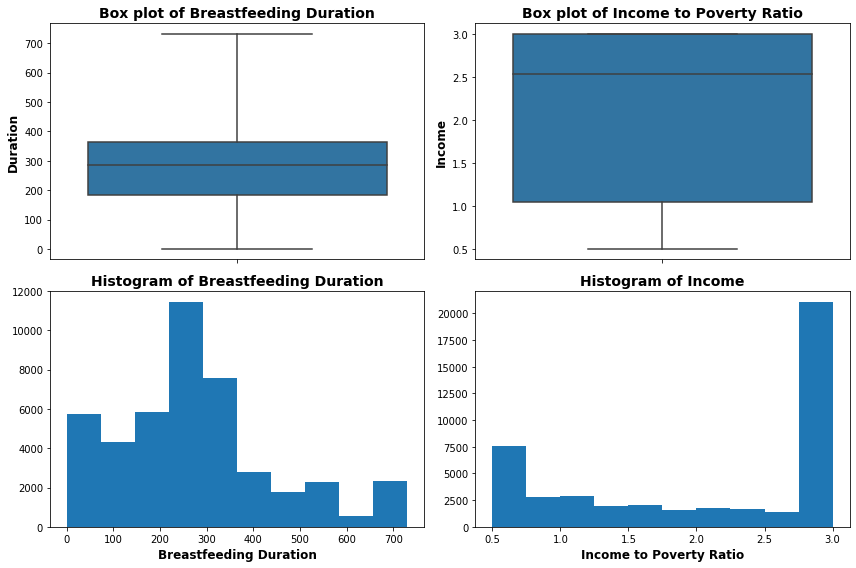

In [19]:
fig = plt.figure(figsize= (12, 8))
plt.subplot(2,2,1)
sns.boxplot(y= train_df.BF_ENDR06, whis=2)
plt.ylabel('Duration', fontsize=12, fontweight='bold')
plt.title('Box plot of Breastfeeding Duration',  fontsize=14, fontweight='bold')

plt.subplot(2,2,2)
sns.boxplot(y= train_df.INCPORAR_I, whis=2)
plt.ylabel('Income', fontsize=12, fontweight='bold')
plt.title('Box plot of Income to Poverty Ratio',  fontsize=14, fontweight='bold')

plt.subplot(2,2,3)
plt.hist(train_df.BF_ENDR06)
plt.xlabel('Breastfeeding Duration', fontsize=12, fontweight='bold')
plt.title('Histogram of Breastfeeding Duration',  fontsize=14, fontweight='bold')

plt.subplot(2,2,4)
plt.hist(train_df.INCPORAR_I)
plt.xlabel('Income to Poverty Ratio', fontsize=12, fontweight='bold')
plt.title('Histogram of Income',  fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [20]:
# MAYBE remove this and just show plots!
q75, q25 = np.percentile(train_df["BF_ENDR06"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((train_df["BF_ENDR06"] > max_val) 
                      | (train_df["BF_ENDR06"] < min_val))[0]))
    ))
 



The score threshold is: 1.0
Number of outliers is: 3136
The score threshold is: 1.5
Number of outliers is: 2319
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


The data are not normally distributed, even after applying Yeojohnson transformation. I will therefore use the 2 continuous variables BF_ENDR06 and INCPORAR_I as they are.

In [21]:
jb_stats = jarque_bera(train_df['BF_ENDR06'])
norm_stats = normaltest(train_df['BF_ENDR06'])

print("Jarque-Bera test statistics for yeojohnson transform is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for yeojohnson transform is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
print('\n')

bf_endr06_yeojohnson,_ = yeojohnson(train_df['BF_ENDR06'])
jb_stats = jarque_bera(bf_endr06_yeojohnson)
norm_stats = normaltest(bf_endr06_yeojohnson)

print("Jarque-Bera test statistics for yeojohnson transform is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for yeojohnson transform is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))



Jarque-Bera test statistics for yeojohnson transform is 2771.704311168191 and p value is 0.0
Normality test statistics for yeojohnson transform is 2377.0605862423904 and p value is 0.0


Jarque-Bera test statistics for yeojohnson transform is 240.88494806332812 and p value is 0.0
Normality test statistics for yeojohnson transform is 285.58312110684034 and p value is 9.691995175812363e-63


Let's repeat the same data cleaning on the test set

In [22]:
# Replace '.' values with NaN and convert data to numeric.
for col in zip(test_df.columns):
  test_df[col[0]] = test_df[col[0]].apply(str.strip).replace('.', np.nan)
  test_df[col[0]] = pd.to_numeric(test_df[col[0]])

test_df = test_df[~((test_df.INS_STAT2_I.isnull()))]
test_df = test_df[~((test_df.PROV_FAC.isnull()))]

test_df['PROV_FAC'] = test_df['PROV_FAC'].astype('int64')
test_df['INS_STAT2_I'] = test_df['INS_STAT2_I'].astype('int64')

# Remove reserved codes which account for less than 2% of the data.
test_df = test_df[~((test_df.CBF_01 == 77) | (test_df.CBF_01 == 99))]
test_df = test_df[~((test_df.CWIC_01 == 3) | (test_df.CWIC_01 == 77) | (test_df.CWIC_01 == 99))]
test_df = test_df[~((test_df.RENT_OWN == 77) | (test_df.RENT_OWN == 99))]
test_df = test_df[~((test_df.PROV_FAC == 6))]

test_df.reset_index(drop = True, inplace = True)

test_df.loc[test_df['BF_ENDR06'].isnull(), ['BF_ENDR06']] = test_df.BF_ENDR06.mean()


### 3 - What are the socio-economic and demograhic characteristics of children not up-to-date with their vaccines?

- Children who go to private health provider facilities are more likely to be immunized compared to those who go to other types of provider facility.
- Children with private insurance are more likely to be immunized compared to those with other types of insurance.
- Children of mothers with high level of education are more likely to be immunized compared to those from mothers with lower education level, with children of college graduates having the highest level of immunization and those of high school level having the lowest percentage of immunization.
- Non-Hispanic Black children are less likely to be up-to-date with their vaccines compared to their peers from other race/ethnicity.

I performed ChiSquare tests and found that the differences observed are statistically significant.

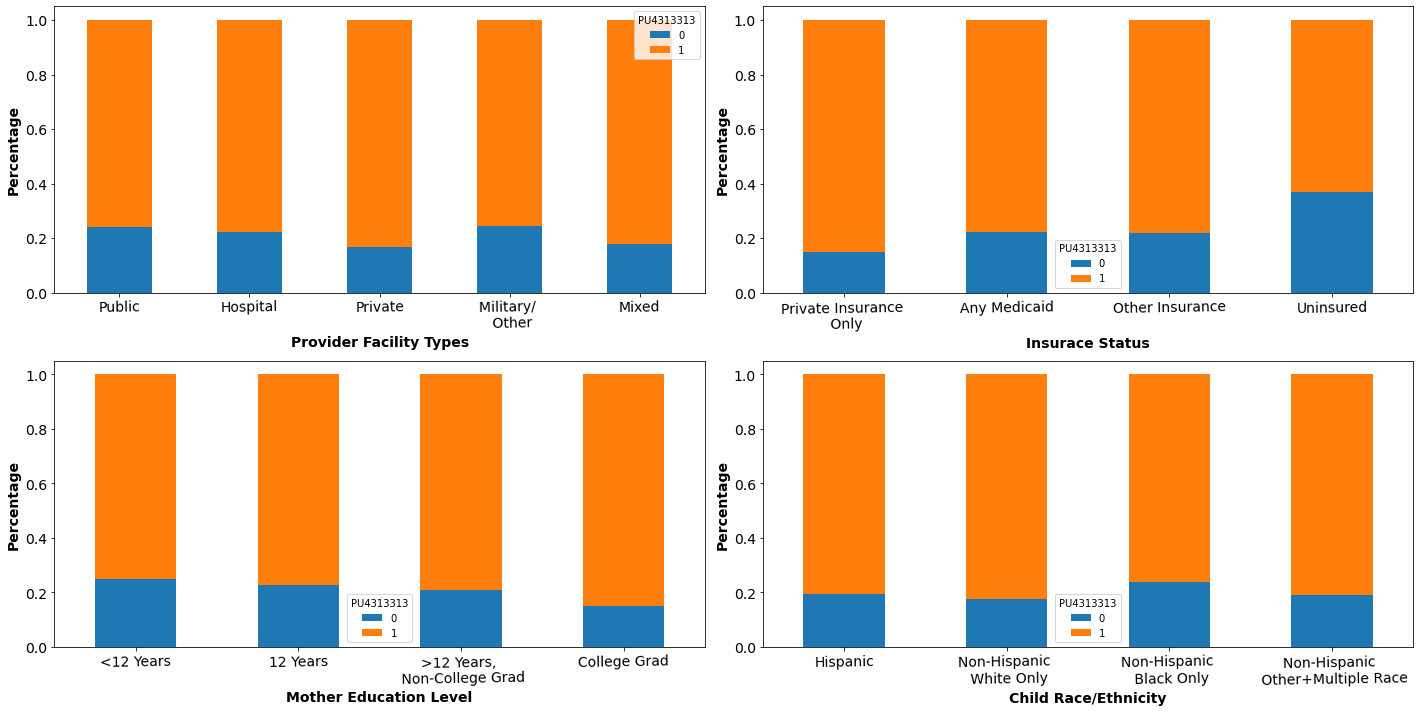

In [23]:
plot_cat_list_rename = ['Provider Facility Types', 'Insurace Status', 'Mother Education Level', 'Child Race/Ethnicity']

fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2, 2, figsize=(20, 10))

df_sum_provfac = train_df.groupby(['PU4313313', 'PROV_FAC']).size()[0] + train_df.groupby(['PU4313313', 'PROV_FAC']).size()[1]
(train_df.groupby(['PU4313313', 'PROV_FAC']).size() / df_sum_provfac).reset_index().pivot(columns='PU4313313', index='PROV_FAC', values=0).plot(kind='bar', stacked=True, rot=1, legend=True, ax=axis1)

df_sum_instat2i = train_df.groupby(['PU4313313', 'INS_STAT2_I']).size()[0] + train_df.groupby(['PU4313313', 'INS_STAT2_I']).size()[1]
(train_df.groupby(['PU4313313', 'INS_STAT2_I']).size() / df_sum_instat2i).reset_index().pivot(columns='PU4313313', index='INS_STAT2_I', values=0).plot(kind='bar', stacked=True, rot=1, legend=True, ax=axis2)

df_sum_educ1 = train_df.groupby(['PU4313313', 'EDUC1']).size()[0] + train_df.groupby(['PU4313313', 'EDUC1']).size()[1]
(train_df.groupby(['PU4313313', 'EDUC1']).size() / df_sum_educ1).reset_index().pivot(columns='PU4313313', index='EDUC1', values=0).plot(kind='bar', stacked=True, rot=1, legend=True, ax=axis3)

df_sum_raceethk = train_df.groupby(['PU4313313', 'RACEETHK']).size()[0] + train_df.groupby(['PU4313313', 'RACEETHK']).size()[1]
(train_df.groupby(['PU4313313', 'RACEETHK']).size() / df_sum_raceethk).reset_index().pivot(columns='PU4313313', index='RACEETHK', values=0).plot(kind='bar', stacked=True, rot=1, legend=True, ax=axis4)

labels1 = [item.get_text() for item in axis1.get_xticklabels()]
labels1[0] = 'Public'
labels1[1] = 'Hospital'
labels1[2] = 'Private'
labels1[3] = 'Military/ \n Other'
labels1[4] = 'Mixed'

labels2 = [item.get_text() for item in axis2.get_xticklabels()]
labels2[0] = 'Private Insurance \n Only'
labels2[1] = 'Any Medicaid' 
labels2[2] = 'Other Insurance'
labels2[3] = 'Uninsured' 

labels3 = [item.get_text() for item in axis3.get_xticklabels()]
labels3[0] = '<12 Years'
labels3[1] = '12 Years'
labels3[2] = '>12 Years, \n Non-College Grad'
labels3[3] = 'College Grad'

labels4 = [item.get_text() for item in axis4.get_xticklabels()]
labels4[0] = 'Hispanic'
labels4[1] = 'Non-Hispanic \n White Only'
labels4[2] = 'Non-Hispanic \n Black Only'
labels4[3] = 'Non-Hispanic \n Other+Multiple Race'


axis1.set_xticklabels(labels1)
axis2.set_xticklabels(labels2)
axis3.set_xticklabels(labels3)
axis4.set_xticklabels(labels4)

for i, ax in enumerate([axis1, axis2, axis3, axis4]):
    # ax.set_ylim([0, 27000])
    ax.set_ylabel('Percentage', fontsize = 14, fontweight= 'bold')
    ax.set_xlabel(plot_cat_list_rename[i], fontsize = 14, fontweight= 'bold')
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()


In [24]:
plot_cat_list = ['PROV_FAC', 'INS_STAT2_I', 'EDUC1', 'RACEETHK']

for i, col in enumerate(plot_cat_list):
  count_table = pd.crosstab(train_df['PU4313313'], train_df[col])
  print('ChiSquare result of {} is {}: '.format(plot_cat_list_rename[i], stats.chisquare(count_table, axis=None))) # [1] to print only p-value.

ChiSquare result of Provider Facility Types is Power_divergenceResult(statistic=72323.18497368714, pvalue=0.0): 
ChiSquare result of Insurace Status is Power_divergenceResult(statistic=64264.3650878961, pvalue=0.0): 
ChiSquare result of Mother Education Level is Power_divergenceResult(statistic=41731.605396932035, pvalue=0.0): 
ChiSquare result of Child Race/Ethnicity is Power_divergenceResult(statistic=56963.72220356063, pvalue=0.0): 


### 3 -  Which states have the highest percentage of unvaccinated children?
I computed the percentage of vaccinated and unvaccinated children per state per each year 2016 through 2018. I am showing the top 5 states with the highest percentage of unvaccinated children or lowest percentage of vaccinated children which is well below the national average for that year shown in orange. The national average increases every year, but hasn't yet reached the goal defined by the CDC program Healthy People 2020 objectives, of having at least 90% of 2-year old children fully vaccinated with most recommended vaccine series.


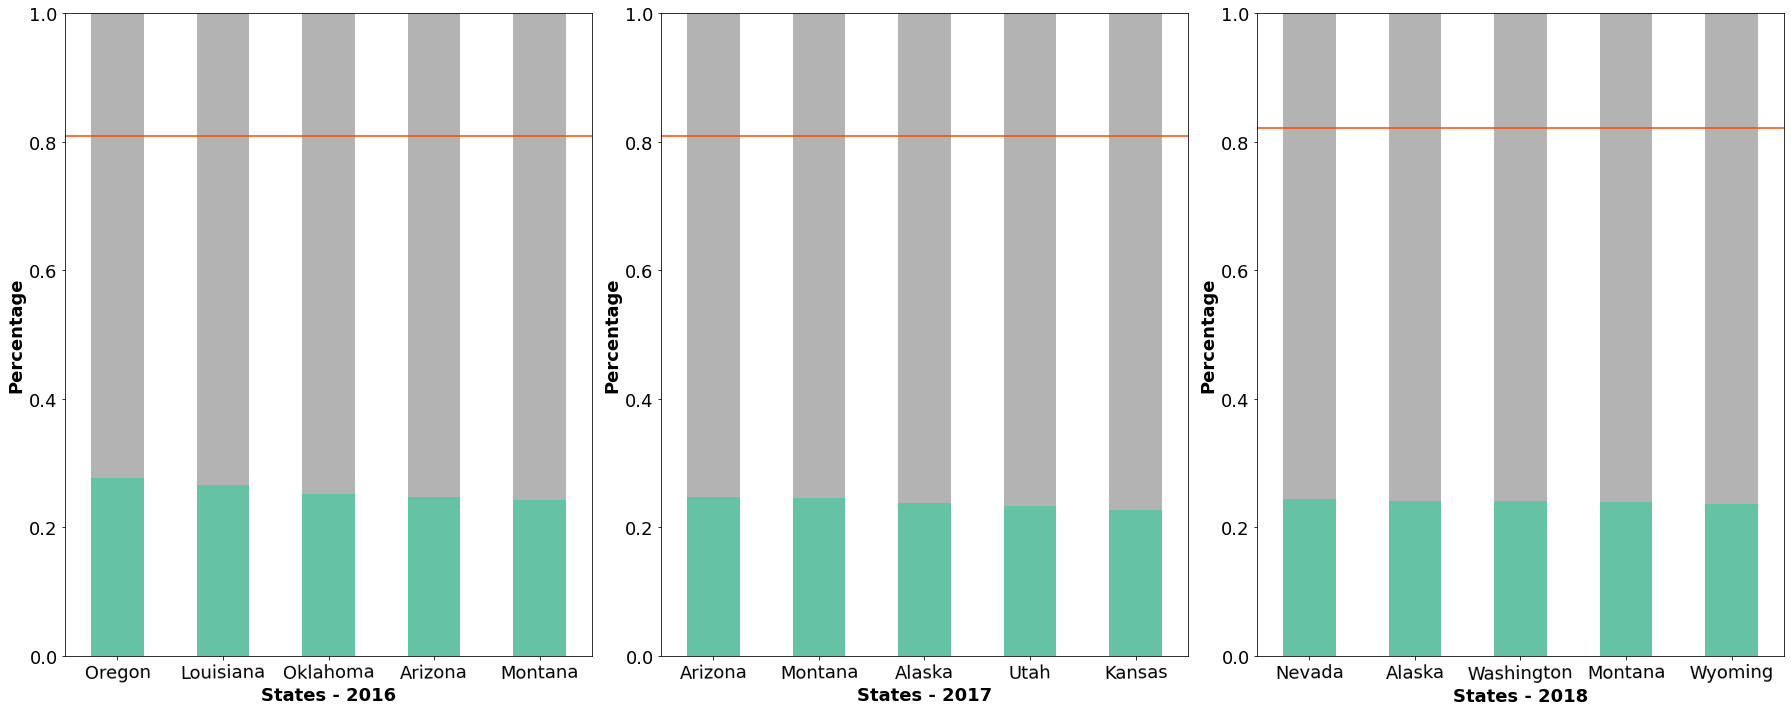

In [89]:
plot_states_list = ['States - 2016', 'States - 2017', 'States - 2018']

train_df_16 = train_df.loc[train_df.YEAR==2016].copy()
train_df_17 = train_df.loc[train_df.YEAR==2017].copy()
train_df_18 = train_df.loc[train_df.YEAR==2018].copy()

df_sum_state_16 = train_df_16.groupby(['PU4313313', 'STATE']).size()[0] + train_df_16.groupby(['PU4313313', 'STATE']).size()[1]
df_sum_state_17 = train_df_17.groupby(['PU4313313', 'STATE']).size()[0] + train_df_17.groupby(['PU4313313', 'STATE']).size()[1]
df_sum_state_18 = train_df_18.groupby(['PU4313313', 'STATE']).size()[0] + train_df_18.groupby(['PU4313313', 'STATE']).size()[1]

fig, ((axis1, axis2, axis3)) = plt.subplots(1, 3, figsize=(25, 10))

(train_df_16.groupby(['PU4313313', 'STATE']).size() / df_sum_state_16).reset_index().pivot(columns='PU4313313', index='STATE', values=0).sort_values([0], ascending=False)[:5].plot(
    kind='bar', stacked=True, rot=1, colormap='Set2', legend=False, ax=axis1)
axis1.hlines((train_df_16.groupby(['PU4313313', 'STATE']).size() / df_sum_state_16).reset_index().pivot(columns='PU4313313', index='STATE', values=0).mean()[1], 
           xmin=-1, xmax=56, color='orangered')

(train_df_17.groupby(['PU4313313', 'STATE']).size() / df_sum_state_17).reset_index().pivot(columns='PU4313313', index='STATE', values=0).sort_values([0], ascending=False)[:5].plot(
    kind='bar', stacked=True, rot=1, colormap='Set2', legend=False, ax=axis2)
axis2.hlines((train_df_17.groupby(['PU4313313', 'STATE']).size() / df_sum_state_17).reset_index().pivot(columns='PU4313313', index='STATE', values=0).mean()[1], 
           xmin=-1, xmax=56, color='orangered')

(train_df_18.groupby(['PU4313313', 'STATE']).size() / df_sum_state_18).reset_index().pivot(columns='PU4313313', index='STATE', values=0).sort_values([0], ascending=False)[:5].plot(
    kind='bar', stacked=True, rot=1, colormap='Set2', legend=False, ax=axis3)
axis3.hlines((train_df_18.groupby(['PU4313313', 'STATE']).size() / df_sum_state_18).reset_index().pivot(columns='PU4313313', index='STATE', values=0).mean()[1], 
           xmin=-1, xmax=56, color='orangered')


labels1 = [item.get_text() for item in axis1.get_xticklabels()]
labels1[0] = 'Oregon'
labels1[1] = 'Louisiana'
labels1[2] = 'Oklahoma'
labels1[3] = 'Arizona'
labels1[4] = 'Montana'

labels2 = [item.get_text() for item in axis2.get_xticklabels()]
labels2[0] = 'Arizona'
labels2[1] = 'Montana' 
labels2[2] = 'Alaska'
labels2[3] = 'Utah' 
labels2[4] = 'Kansas' 

labels3 = [item.get_text() for item in axis3.get_xticklabels()]
labels3[0] = 'Nevada'
labels3[1] = 'Alaska'
labels3[2] = 'Washington'
labels3[3] = 'Montana'
labels3[4] = 'Wyoming'


axis1.set_xticklabels(labels1)
axis2.set_xticklabels(labels2)
axis3.set_xticklabels(labels3)

for i, ax in enumerate([axis1, axis2, axis3]):
    ax.set_ylim([0, 1])
    ax.set_ylabel('Percentage', fontsize = 18, fontweight= 'bold')
    ax.set_xlabel(plot_states_list[i], fontsize = 18, fontweight= 'bold')
    ax.tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout()
plt.show()


### 4 - Optimized baseline models 
Now that I've done some data cleaning, I'd like to apply some models and get some baseline scores.  This way, I'll know if any additional feature engineering is useful or not, or if I need to use any other methods to improve the models.  The models I am choosing are logistic regression, knn, random forest, and light gradient boosting classification. Let me remind that I want to predict whether or not a child is at risk of defaulting from routine immunization vaccine series. 

I will look at accuracy in predicting data in the test set and check for overfitting of the training set. In addition, I'd like to compare two types of scoring: F1-score and specificity.  F1-score is important to know because I have a highly imbalanced class and it can help see if the models are predicting the positive class well or not. Specificity focuses on the negative class and can tell us how well the models are predicting the negative class, which in my case are children not up-to-date with their vaccines. I am therefore interested in obtaining highest F1-score and specificity score, as well as best accuracy possible. There will be some trade-offs between f1-score and specificity to take into consideration. 

#### 4.1 Training and test sets
My data are already split into training (train_df) and test (test_df) sets. I am dropping the column YEAR and AGEGRP for the training, as those are not important for the training of models. I am defining the dataframe of features and vector of target variable for both the training and test sets. I then normalize the dataframe of features to have them at the same scale during training. 

In [26]:
X_train = train_df.drop(['PU4313313', 'YEAR', 'AGEGRP'], axis = 1) 
X_test = test_df.drop(['PU4313313', 'YEAR', 'AGEGRP'], axis = 1) 

y_train = train_df['PU4313313']
y_test = test_df['PU4313313']

# Normalize the data so that all variables have a mean of 0 and standard deviation of 1.
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# Dataframe of X_train_std and X_test_std. It will be useful for feature selection
df_X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
df_X_test_std = pd.DataFrame(X_test_std, columns=X_test.columns)


#### 4.2 Optimized baseline scores
I am training the models with default and optimized parameters. Accuracy, f1-score and specificity for logistic regression, knn, random forest, gradient boost classifiers are summarized in a dataframe further down. 

In [27]:
def get_scores(model_fit, model_name):
    
    train_preds = model_fit.predict(X_train_std)
    test_preds = model_fit.predict(X_test_std)
    
    train_probs = model_fit.predict_proba(X_train_std)
    test_probs = model_fit.predict_proba(X_test_std)
          
    confusion_mat = confusion_matrix(y_test, test_preds, labels=[0, 1]) # [0,1] == [Not UTD, UTD]
    print('Confusion Matrix: \n {}'.format(confusion_mat))

    # Output dictionary for classification_report
    class_report_dict = classification_report(y_test, test_preds, target_names=['Not UTD', 'UTD'], output_dict=True)

    roc_auc_res = roc_auc_score(y_test, test_preds)

    return class_report_dict, roc_auc_res, train_preds, test_preds, train_probs, test_probs

Logistic Regression

In [28]:
lr_clf = LogisticRegression()
lr_pipeline = Pipeline([("logisticregression", lr_clf)])
lr_param_grid = dict(logisticregression__penalty=['l1', 'l2'], logisticregression__solver=['saga', 'lbfgs'], logisticregression__C=[.001, .01, .1, 1, 10],
                  logisticregression__class_weight=[{0: w} for w in [.75, .8, .9, 1, 'None']], logisticregression__max_iter=[1e9], logisticregression__random_state=[145])

lr_grid = GridSearchCV(lr_pipeline, param_grid=lr_param_grid, cv=5, verbose=1, n_jobs=-1)
lr_grid.fit(df_X_train_std.values, y_train)

lr_class_report_dict, lr_roc_auc_res, lr_train_preds, lr_test_preds, lr_train_probs, lr_test_probs = get_scores(lr_grid, 'Logistic Regression')

print()
print(lr_grid.best_params_)



Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 382 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   50.1s finished


Confusion Matrix: 
 [[    0  2775]
 [    3 13159]]

{'logisticregression__C': 0.01, 'logisticregression__class_weight': {0: 1}, 'logisticregression__max_iter': 1000000000.0, 'logisticregression__penalty': 'l2', 'logisticregression__random_state': 145, 'logisticregression__solver': 'saga'}


KNN

There are three main parameters to check for in KNN classification: number of neighbors (k), scaled vs not scaled, and weighted vs non weighted distances. To find the best parameters, I plot the scores as a function of neighbors for each combination of (un)scaled and (un)weighted data. This should produce four plots.

Text(0.5, 1.0, 'Unscaled, Unweighted KNN F1-score vs k')

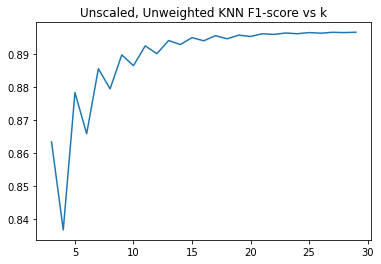

In [29]:
k_range = range(3, 30)
scores_unscaled_nonweight_lst = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)
    score = cross_val_score(knn, X_train, y_train, scoring='f1', cv = 3, n_jobs = -1) 
    scores_unscaled_nonweight_lst.append(score.mean())

plt.plot(k_range, scores_unscaled_nonweight_lst)
plt.title('Unscaled, Unweighted KNN F1-score vs k')


Text(0.5, 1.0, 'Scaled, Unweighted KNN F1-score vs k')

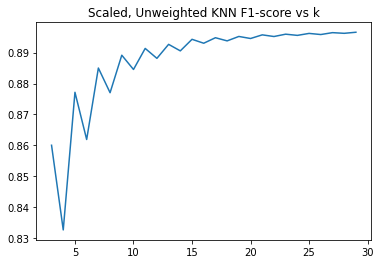

In [30]:
k_range = range(3, 30)
scores_scaled_nonweight_lst = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_std, y_train)
    score = cross_val_score(knn, X_train_std, y_train, cv = 3, scoring = 'f1', n_jobs = -1)
    scores_scaled_nonweight_lst.append(score.mean())

plt.plot(k_range, scores_scaled_nonweight_lst)
plt.title('Scaled, Unweighted KNN F1-score vs k')


Text(0.5, 1.0, 'Unscaled, weighted KNN F1-score vs k')

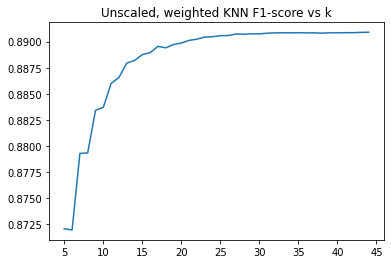

In [31]:
k_range = range(5, 45)
scores_unscaled_weight_lst = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, weights='distance')
    knn.fit(X_train, y_train)
    score = cross_val_score(knn, X_train, y_train, cv = 3, scoring = 'f1', n_jobs = -1)
    scores_unscaled_weight_lst.append(score.mean())

plt.plot(k_range, scores_unscaled_weight_lst)
plt.title('Unscaled, weighted KNN F1-score vs k')


Text(0.5, 1.0, 'Scaled, weighted KNN F1-score vs k')

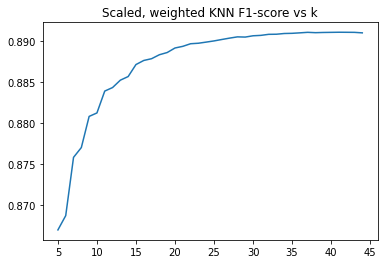

In [32]:
k_range = range(5, 45)
scores_scaled_weight_lst = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, weights='distance')
    knn.fit(X_train_std, y_train)
    score = cross_val_score(knn, X_train_std, y_train, cv = 3, scoring = 'f1', n_jobs = -1)
    scores_scaled_weight_lst.append(score.mean())

# k = 
plt.plot(k_range, scores_scaled_weight_lst)
plt.title('Scaled, weighted KNN F1-score vs k')


The final KNN parameters are chosen where the curve is stable, k= 40 neighbors, for the scaled and weighted KNN.

In [34]:
knn_clf = KNeighborsClassifier()
knn_pipeline = Pipeline([("knn", knn_clf)])
knn_param_grid = dict(knn__n_neighbors=[40], knn__weights=['distance']) 

knn_grid = GridSearchCV(knn_pipeline, param_grid=knn_param_grid, cv=5, verbose=1, n_jobs=-1)
knn_grid.fit(df_X_train_std.values, y_train)

knn_class_report_dict, knn_roc_auc_res, knn_train_preds, knn_test_preds, knn_train_probs, knn_test_probs = get_scores(knn_grid, 'KNN')

print()
print(knn_grid.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.3s finished


Confusion Matrix: 
 [[   40  2735]
 [  197 12965]]

{'knn__n_neighbors': 40, 'knn__weights': 'distance'}


Random Forest Classifier

In [35]:
rf_clf = RandomForestClassifier()
rf_pipeline = Pipeline([("randomforest", rf_clf)])
rf_param_grid = dict(randomforest__criterion=['entropy'], randomforest__n_estimators=[500, 700], randomforest__max_depth=[25, 40], 
                     randomforest__min_samples_leaf=[1, 3], randomforest__class_weight=[{0: w} for w in [.75, .8]], randomforest__random_state=[145])

rf_grid = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, cv=5, verbose=5, n_jobs=-1)
rf_grid.fit(df_X_train_std.values, y_train)

rf_class_report_dict, rf_roc_auc_res, rf_train_preds, rf_test_preds, rf_train_probs, rf_test_probs = get_scores(rf_grid, 'Random Forest')

print()
print(rf_grid.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 29.6min finished


Confusion Matrix: 
 [[   23  2752]
 [   14 13148]]

{'randomforest__class_weight': {0: 0.8}, 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 40, 'randomforest__min_samples_leaf': 3, 'randomforest__n_estimators': 700, 'randomforest__random_state': 145}


Light Gradient Boosting Machine Classifier

In [36]:
lgbm_clf = LGBMClassifier()
lgbm_pipeline = Pipeline([("lightgbm", lgbm_clf)])
lgbm_param_grid = dict(lightgbm__max_depth=[6,7], lightgbm__num_leaves=[40,50], lightgbm__n_estimators=[500,800], lightgbm__objective=['binary'],
                  lightgbm__learning_rate=[.01, .1], lightgbm__min_child_samples=[80, 120], lightgbm__class_weight=[{0: w} for w in [.75, .8]], lightgbm__random_state=[145])

lgbm_grid = GridSearchCV(lgbm_pipeline, param_grid=lgbm_param_grid, cv=5, verbose=1, n_jobs=-1)
lgbm_grid.fit(df_X_train_std.values, y_train)

lgbm_class_report_dict, lgbm_roc_auc_res, lgbm_train_preds, lgbm_test_preds, lgbm_train_probs, lgbm_test_probs = get_scores(lgbm_grid, 'Light Gradient Boosting Machine')

print()
print(lgbm_grid.best_params_)


Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 18.3min finished


Confusion Matrix: 
 [[   24  2751]
 [   17 13145]]

{'lightgbm__class_weight': {0: 0.8}, 'lightgbm__learning_rate': 0.01, 'lightgbm__max_depth': 6, 'lightgbm__min_child_samples': 80, 'lightgbm__n_estimators': 500, 'lightgbm__num_leaves': 50, 'lightgbm__objective': 'binary', 'lightgbm__random_state': 145}


I can look at the accuracies and the 2 most important metrics: F1-score and Specificity. Accuracy is not really useful to assess the best models, as it is about 82% for all of them. F1-score is very high for all models (about 90%), but specificity is null (0%). This is due to the fact that I have a highly imbalanced class (positive class (vaccianted children) is a little over 4 times the negative class (unvaccinated children)), which even the regularized parameter class_weight couldn't handle well. 

In [37]:
# DF of accuracy
accuracy_dictionary = {
    'Logistic Regression' : [accuracy_score(y_train, lr_train_preds), lr_class_report_dict['accuracy']],
    'KNN' : [accuracy_score(y_train, knn_train_preds), knn_class_report_dict['accuracy']],
    'Random Forest' : [accuracy_score(y_train, rf_train_preds), rf_class_report_dict['accuracy']],
    'Gradient Boost' : [accuracy_score(y_train, lgbm_train_preds), lgbm_class_report_dict['accuracy']]
}
accuracy_df = pd.DataFrame(accuracy_dictionary, index= ['Training Accuracy', 'Test Accuracy'])
accuracy_df.round(2)



,Logistic Regression,KNN,Random Forest,Gradient Boost
Training Accuracy,0.81,0.99,0.83,0.81
Test Accuracy,0.83,0.82,0.83,0.83


In [43]:
# DF of key performance metrics
list_arrays = [
               np.array(["Not UTD", "Not UTD", "Not UTD", "UTD", "UTD", "UTD"]),
               np.array(["Precision score", "Specificity", "F1-score", "Precision score", "Recall/Sensitivity", "F1-score"])
               ]

performance_metrics_array = np.array(
  [(np.array([lr_class_report_dict['Not UTD']['precision'], lr_class_report_dict['Not UTD']['recall'], lr_class_report_dict['Not UTD']['f1-score'],
              lr_class_report_dict['UTD']['precision'], lr_class_report_dict['UTD']['recall'], lr_class_report_dict['UTD']['f1-score']])),
   (np.array([knn_class_report_dict['Not UTD']['precision'], knn_class_report_dict['Not UTD']['recall'], knn_class_report_dict['Not UTD']['f1-score'],
              knn_class_report_dict['UTD']['precision'], knn_class_report_dict['UTD']['recall'], knn_class_report_dict['UTD']['f1-score']])),
    (np.array([rf_class_report_dict['Not UTD']['precision'], rf_class_report_dict['Not UTD']['recall'], rf_class_report_dict['Not UTD']['f1-score'],
               rf_class_report_dict['UTD']['precision'], rf_class_report_dict['UTD']['recall'], rf_class_report_dict['UTD']['f1-score']])), 
   (np.array([lgbm_class_report_dict['Not UTD']['precision'], lgbm_class_report_dict['Not UTD']['recall'], lgbm_class_report_dict['Not UTD']['f1-score'],
              lgbm_class_report_dict['UTD']['precision'], lgbm_class_report_dict['UTD']['recall'], lgbm_class_report_dict['UTD']['f1-score']]))]
    )

performance_metrics_df = pd.DataFrame(performance_metrics_array.T, index=list_arrays, columns=['Logistic Regression', 'KNN', 'Random Forest', 'Gradient Boost'])
performance_metrics_df.round(2)


Logistic Regression   KNN  Random Forest  \
Not UTD Precision score                    0.00  0.17           0.62   
        Specificity                        0.00  0.01           0.01   
        F1-score                           0.00  0.03           0.02   
UTD     Precision score                    0.83  0.83           0.83   
        Recall/Sensitivity                 1.00  0.99           1.00   
        F1-score                           0.90  0.90           0.90   

                            Gradient Boost  
Not UTD Precision score               0.59  
        Specificity                   0.01  
        F1-score                      0.02  
UTD     Precision score               0.83  
        Recall/Sensitivity            1.00  
        F1-score                      0.90

### 5- Improving the Models
From the classification report in the last section, the positive class (1) consistently did much better than the negative class (0).  Most likely this is due to the imbalance in classes.  A simple way to correct for this is to over or under sample before training the model.  For this, I will use the imbalanced-learn library. Oversampling and Undersampling are applied only on the training set, with features scaled. This helps avoid data leakage.

#### 5.1 - Oversampling
With oversampling, the two methods I will use are SMOTE-NC and Random Oversampling.  

##### 5.1.1 - SMOTE-NC
SMOTE-NC, which stands for Synthetic Minority Oversampling Technique for Nominal and Continuous features, is another oversampling method that aims to balance class distribution by randomly increasing minority class examples by replicating them. SMOTE-NC creates new synthetic data for categorical and quantitative features by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each sample in the minority class. 

One of the hyperparameters for the SMOTE-NC method is k_neighbors.  For the Logistic Regression, KNN, Random Forest and Light Gradient Boosting Machine methods, I plotted the specificity against the the number of k_neighbors to find the optimal number of neighbors. Because specificity and f1-score are very important for this study, for all models, I choose k_neighbors which gives me the best trade-off between f1-score and specificity. 

After choosing k_neighbors, I ran again SMOTE-NC this time with optimized parameters for the models in order to improve the performance metrics. Logistic Regression performed the best in terms of specificity with about 57% and Gradient Boosting and Random Forest did better on f1-score, with Gradient Boost having the best trade-off between f1-score and specificity. The test accuracy is the best for Random Forest (67%) and Gradient Boost (63%).

The results are in the following table: 

|    |  K-neighbors  | Specificity  |  Specificity Optimized  |
|------|------|------|------|
|  Logistic Regression  |  1  |  57.3%  |  57.3%  |
|  KNN  |  5  |  41.1%  |  54%  |
|  Random Forest  |  5  |  20.2%  |  34%  |
|  Gradient Boost  |  1  |  32.9%  |  44%  |



SMOTE-NC for Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

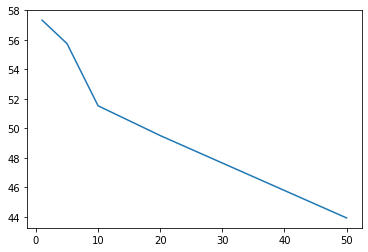

In [44]:
num_indices1 = list(df_X_train_std.iloc[:,np.r_[0,7]].columns.values)
cat_indices1 = list(df_X_train_std.iloc[:,np.r_[1:7,8:17]].columns.values)
cat_indices = [1,2,3,4,5,6,8,9,10,11,12,13,14,15,16]

smotenc_lr_scores = []
smotenc_lr_range = [1,5,10,20,50]  
for k in smotenc_lr_range:
    lr_tmp_pipeline = make_pipeline(
    SMOTENC(categorical_features=cat_indices, k_neighbors = k, random_state = 145),
    LogisticRegression(n_jobs=-1, random_state=145),
)
    lr_tmp_pipeline.fit(X_train_std, y_train);
    lr_tmp_prediction = lr_tmp_pipeline.predict(X_test_std)
    smotenc_lr_scores.append(recall_score(y_test, lr_tmp_prediction, pos_label=0)*100)

plt.plot(smotenc_lr_range, smotenc_lr_scores)    
plt.show()

In [45]:
# Default parameters
pipeline_smnc_lr = make_pipeline(SMOTENC(categorical_features=cat_indices, k_neighbors = 1, random_state = 145), 
                                   LogisticRegression(n_jobs=-1, random_state=145))
pipeline_smnc_lr.fit(df_X_train_std.values, y_train)
smnc_lr_class_report_dict, smnc_lr_roc_auc_res, smnc_lr_train_preds, smnc_lr_test_preds, smnc_lr_train_probs, smnc_lr_test_probs = get_scores(pipeline_smnc_lr, 'LR SMOTENC')

smnc_lr_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1591 1184]
 [5206 7956]]


{'Not UTD': {'f1-score': 0.33242791475135813,
  'precision': 0.23407385611299103,
  'recall': 0.5733333333333334,
  'support': 2775},
 'UTD': {'f1-score': 0.7134786117836966,
  'precision': 0.8704595185995624,
  'recall': 0.6044674061692752,
  'support': 13162},
 'accuracy': 0.5990462445880655,
 'macro avg': {'f1-score': 0.5229532632675273,
  'precision': 0.5522666873562767,
  'recall': 0.5889003697513042,
  'support': 15937},
 'weighted avg': {'f1-score': 0.647128879446071,
  'precision': 0.7596500680505107,
  'recall': 0.5990462445880655,
  'support': 15937}}

In [46]:
# Optimized parameters
pipeline_smnc_lr = make_pipeline(SMOTENC(categorical_features=cat_indices, k_neighbors = 1, random_state = 145), 
                                   LogisticRegression(penalty='l2', solver='saga', C=.01, max_iter=1e9, n_jobs=-1, random_state = 145))
pipeline_smnc_lr.fit(df_X_train_std.values, y_train)
smnc_lr_class_report_dict, smnc_lr_roc_auc_res, smnc_lr_train_preds, smnc_lr_test_preds, smnc_lr_train_probs, smnc_lr_test_probs = get_scores(pipeline_smnc_lr, 'LR SMOTENC')

smnc_lr_class_report_dict

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1589 1186]
 [5200 7962]]


{'Not UTD': {'f1-score': 0.3322877457130908,
  'precision': 0.23405508911474443,
  'recall': 0.5726126126126126,
  'support': 2775},
 'UTD': {'f1-score': 0.7137606454504707,
  'precision': 0.870354175776126,
  'recall': 0.6049232639416502,
  'support': 13162},
 'accuracy': 0.5992972328543641,
 'macro avg': {'f1-score': 0.5230241955817807,
  'precision': 0.5522046324454352,
  'recall': 0.5887679382771314,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6473373978649007,
  'precision': 0.7595598000789852,
  'recall': 0.5992972328543641,
  'support': 15937}}

SMOTE-NC for KNN

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

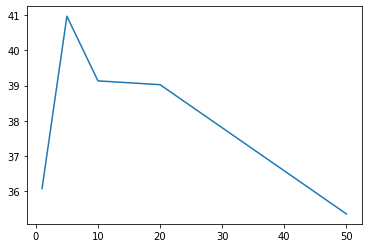

In [47]:
smotenc_knn_scores = []
smotenc_knn_range = [1,5,10,20,50] 
for k in smotenc_knn_range:
    knn_tmp_pipeline = make_pipeline(
    SMOTENC(categorical_features=cat_indices, k_neighbors = k, random_state = 145),
    KNeighborsClassifier(n_jobs=-1),
)
    knn_tmp_pipeline.fit(X_train_std, y_train);
    knn_tmp_prediction = knn_tmp_pipeline.predict(X_test_std)
    smotenc_knn_scores.append(recall_score(y_test, knn_tmp_prediction, pos_label=0)*100)

plt.plot(smotenc_knn_range, smotenc_knn_scores)    
plt.show()

In [48]:
# Default parameters 
pipeline_smnc_knn = make_pipeline(SMOTENC(categorical_features=cat_indices, k_neighbors = 5, random_state = 145), 
                                   KNeighborsClassifier(n_jobs=-1))
pipeline_smnc_knn.fit(df_X_train_std.values, y_train)
smnc_knn_class_report_dict, smnc_knn_roc_auc_res, smnc_knn_train_preds, smnc_knn_test_preds, smnc_knn_train_probs, smnc_knn_test_probs = get_scores(pipeline_smnc_knn, 'KNN SMOTENC')

smnc_knn_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1137 1638]
 [4308 8854]]


{'Not UTD': {'f1-score': 0.2766423357664234,
  'precision': 0.20881542699724517,
  'recall': 0.4097297297297297,
  'support': 2775},
 'UTD': {'f1-score': 0.7486260251965839,
  'precision': 0.8438810522302707,
  'recall': 0.6726941194347363,
  'support': 13162},
 'accuracy': 0.6269059421472046,
 'macro avg': {'f1-score': 0.5126341804815037,
  'precision': 0.5263482396137579,
  'recall': 0.541211924582233,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6664427574442656,
  'precision': 0.7333014506727852,
  'recall': 0.6269059421472046,
  'support': 15937}}

In [49]:
# Optimized parameters
pipeline_smnc_knn = make_pipeline(SMOTENC(categorical_features=cat_indices, k_neighbors = 5, random_state = 145), 
                                   KNeighborsClassifier(n_neighbors=40, weights='distance', n_jobs=-1))
pipeline_smnc_knn.fit(df_X_train_std.values, y_train)
smnc_knn_class_report_dict, smnc_knn_roc_auc_res, smnc_knn_train_preds, smnc_knn_test_preds, smnc_knn_train_probs, smnc_knn_test_probs = get_scores(pipeline_smnc_knn, 'KNN SMOTENC')

smnc_knn_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1508 1267]
 [5855 7307]]


{'Not UTD': {'f1-score': 0.2974945748668376,
  'precision': 0.20480782289827515,
  'recall': 0.5434234234234234,
  'support': 2775},
 'UTD': {'f1-score': 0.6723408170776591,
  'precision': 0.8522276650338232,
  'recall': 0.5551587904573773,
  'support': 13162},
 'accuracy': 0.5531153918554308,
 'macro avg': {'f1-score': 0.4849176959722484,
  'precision': 0.5285177439660491,
  'recall': 0.5492911069404003,
  'support': 15937},
 'weighted avg': {'f1-score': 0.607071423707826,
  'precision': 0.739496908810811,
  'recall': 0.5531153918554308,
  'support': 15937}}

SMOTE-NC for Random Forest

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

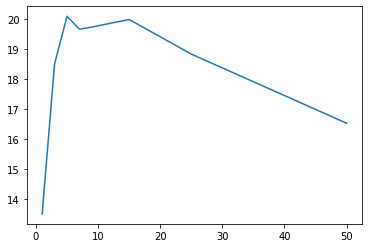

In [50]:
num_indices1 = list(df_X_train_std.iloc[:,np.r_[0,7]].columns.values)
cat_indices1 = list(df_X_train_std.iloc[:,np.r_[1:7,8:17]].columns.values)
cat_indices = [1,2,3,4,5,6,8,9,10,11,12,13,14,15,16]

smotenc_rf_scores = []
smotenc_rf_range = [1,3,5,7,9,15,25,50]  
for k in smotenc_rf_range:
    rf_tmp_pipeline = make_pipeline(
    SMOTENC(categorical_features=cat_indices, k_neighbors = k, random_state = 145),
    RandomForestClassifier(n_jobs=-1),
)
    rf_tmp_pipeline.fit(X_train_std, y_train);
    rf_tmp_prediction = rf_tmp_pipeline.predict(X_test_std)
    smotenc_rf_scores.append(recall_score(y_test, rf_tmp_prediction, pos_label=0)*100)

plt.plot(smotenc_rf_range, smotenc_rf_scores)    
plt.show()

In [51]:
# Default parameters 
pipeline_smnc_rf = make_pipeline(SMOTENC(categorical_features=cat_indices, k_neighbors = 5, random_state = 145), RandomForestClassifier(random_state = 145, n_jobs=-1))
pipeline_smnc_rf.fit(df_X_train_std.values, y_train)
smnc_rf_class_report_dict, smnc_rf_roc_auc_res, smnc_rf_train_preds, smnc_rf_test_preds, smnc_rf_train_probs, smnc_rf_test_probs = get_scores(pipeline_smnc_rf, 'RF SMOTENC')

smnc_rf_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[  571  2204]
 [ 2279 10883]]


{'Not UTD': {'f1-score': 0.20302222222222222,
  'precision': 0.20035087719298245,
  'recall': 0.20576576576576577,
  'support': 2775},
 'UTD': {'f1-score': 0.8292125414301498,
  'precision': 0.831588599373424,
  'recall': 0.8268500227928887,
  'support': 13162},
 'accuracy': 0.7187049005458995,
 'macro avg': {'f1-score': 0.5161173818261859,
  'precision': 0.5159697382832032,
  'recall': 0.5163078942793272,
  'support': 15937},
 'weighted avg': {'f1-score': 0.7201783357576895,
  'precision': 0.7216755241992554,
  'recall': 0.7187049005458995,
  'support': 15937}}

In [52]:
# Optimized parameters 
pipeline_smnc_rf = make_pipeline(SMOTENC(categorical_features=cat_indices, k_neighbors = 5, random_state = 145), 
                                   RandomForestClassifier(criterion='entropy', n_estimators=700, max_depth=16, min_samples_leaf=3, n_jobs=-1, random_state = 145))
pipeline_smnc_rf.fit(df_X_train_std.values, y_train)
smnc_rf_class_report_dict, smnc_rf_roc_auc_res, smnc_rf_train_preds, smnc_rf_test_preds, smnc_rf_train_probs, smnc_rf_test_probs = get_scores(pipeline_smnc_rf, 'RF SMOTENC')

smnc_rf_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[ 944 1831]
 [3365 9797]]


{'Not UTD': {'f1-score': 0.26651609260304915,
  'precision': 0.21907635182176838,
  'recall': 0.3401801801801802,
  'support': 2775},
 'UTD': {'f1-score': 0.790399354578459,
  'precision': 0.8425352597179222,
  'recall': 0.7443397659930102,
  'support': 13162},
 'accuracy': 0.6739662420781829,
 'macro avg': {'f1-score': 0.528457723590754,
  'precision': 0.5308058057698453,
  'recall': 0.5422599730865952,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6991791718601456,
  'precision': 0.7339766558770596,
  'recall': 0.6739662420781829,
  'support': 15937}}

SMOTE-NC for Light Gradient Boosting Machine

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

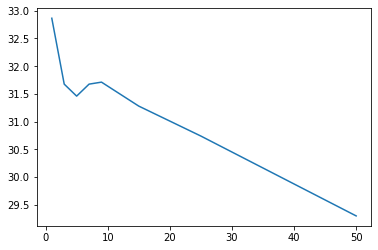

In [53]:
num_indices1 = list(df_X_train_std.iloc[:,np.r_[0,7]].columns.values)
cat_indices1 = list(df_X_train_std.iloc[:,np.r_[1:7,8:17]].columns.values)
cat_indices = [1,2,3,4,5,6,8,9,10,11,12,13,14,15,16]

smotenc_lgbm_scores = []
smotenc_lgbm_range = [1,3,5,7,9,15,25,50] #[1,3,5,7,9] 
for k in smotenc_lgbm_range:
    lgbm_tmp_pipeline = make_pipeline(
    SMOTENC(categorical_features=cat_indices, k_neighbors = k, random_state = 145),
    LGBMClassifier(random_state=145, n_jobs=-1),
)
    lgbm_tmp_pipeline.fit(X_train_std, y_train);
    lgbm_tmp_prediction = lgbm_tmp_pipeline.predict(X_test_std)
    smotenc_lgbm_scores.append(recall_score(y_test, lgbm_tmp_prediction, pos_label=0)*100)

plt.plot(smotenc_lgbm_range, smotenc_lgbm_scores)    
plt.show()

In [54]:
# Default parameters
pipeline_smnc_lgbm = make_pipeline(SMOTENC(categorical_features=cat_indices, k_neighbors = 1, random_state = 145), 
                                   LGBMClassifier(random_state=145, n_jobs=-1))
pipeline_smnc_lgbm.fit(df_X_train_std.values, y_train)
smnc_lgbm_class_report_dict, smnc_lgbm_roc_auc_res, smnc_lgbm_train_preds, smnc_lgbm_test_preds, smnc_lgbm_train_probs, smnc_lgbm_test_probs = get_scores(pipeline_smnc_lgbm, 'LGBM SMOTENC')

smnc_lgbm_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[ 912 1863]
 [3376 9786]]


{'Not UTD': {'f1-score': 0.2582472037377885,
  'precision': 0.2126865671641791,
  'recall': 0.3286486486486486,
  'support': 2775},
 'UTD': {'f1-score': 0.788843658054895,
  'precision': 0.8400721091939223,
  'recall': 0.743504026743656,
  'support': 13162},
 'accuracy': 0.6712681182154734,
 'macro avg': {'f1-score': 0.5235454308963418,
  'precision': 0.5263793381790507,
  'recall': 0.5360763376961524,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6964545534097314,
  'precision': 0.7308297876068898,
  'recall': 0.6712681182154734,
  'support': 15937}}

In [55]:
# Optimized parameters 
pipeline_smnc_lgbm = make_pipeline(SMOTENC(categorical_features=cat_indices, k_neighbors = 1, random_state = 145), 
                                   LGBMClassifier(learning_rate=.01, max_depth=6, min_child_samples=80, n_estimators=500, num_leaves=50, objective='binary', n_jobs=-1, random_state=145))
pipeline_smnc_lgbm.fit(df_X_train_std.values, y_train)
smnc_lgbm_class_report_dict, smnc_lgbm_roc_auc_res, smnc_lgbm_train_preds, smnc_lgbm_test_preds, smnc_lgbm_train_probs, smnc_lgbm_test_probs = get_scores(pipeline_smnc_lgbm, 'LGBM SMOTENC')

smnc_lgbm_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1213 1562]
 [4315 8847]]


{'Not UTD': {'f1-score': 0.2921835481151391,
  'precision': 0.21942836468885674,
  'recall': 0.4371171171171171,
  'support': 2775},
 'UTD': {'f1-score': 0.750668193967163,
  'precision': 0.8499375540397732,
  'recall': 0.6721622853669655,
  'support': 13162},
 'accuracy': 0.6312354897408546,
 'macro avg': {'f1-score': 0.521425871041151,
  'precision': 0.534682959364315,
  'recall': 0.5546397012420413,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6708354216612481,
  'precision': 0.7401513332674325,
  'recall': 0.6312354897408546,
  'support': 15937}}

##### 5.1.2 - Random Oversampling
Random oversampling means that the model generates new samples in the dataset  by randomly sampling with replacement the current available samples from the minority class until all the classes are represented equally.  

In this case, f1-score and specificity are about the same for Logistic Regression, KNN and Gradient Boost, with the highest specificty (58%, 52% and 53% respectively). Random Forest has the highest f1-score and test accuracy, but performs poorly for specificity compared to the other 3 models. So far, this is the highest test accuracy.


Logistic Regression

In [56]:
# Try with default parameters of Logistic Regression
pipeline_overspld_lr = make_pipeline(RandomOverSampler(random_state = 145), 
                                   LogisticRegression(random_state = 145))
pipeline_overspld_lr.fit(df_X_train_std.values, y_train)
overspld_lr_class_report_dict, overspld_lr_roc_auc_res, overspld_lr_train_preds, overspld_lr_test_preds, overspld_lr_train_probs, overspld_lr_test_probs = get_scores(pipeline_overspld_lr, 'LR OverSampling')

overspld_lr_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1598 1177]
 [5030 8132]]


{'Not UTD': {'f1-score': 0.33989152398170797,
  'precision': 0.2410983705491853,
  'recall': 0.5758558558558559,
  'support': 2775},
 'UTD': {'f1-score': 0.7237773129811758,
  'precision': 0.8735632183908046,
  'recall': 0.6178392341589424,
  'support': 13162},
 'accuracy': 0.6105289577712242,
 'macro avg': {'f1-score': 0.5318344184814419,
  'precision': 0.557330794469995,
  'recall': 0.5968475450073991,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6569339256138216,
  'precision': 0.7634364722804644,
  'recall': 0.6105289577712242,
  'support': 15937}}

In [57]:
# Optimized parameters of Logistic Regression
pipeline_overspld_lr = make_pipeline(RandomOverSampler(random_state = 145), 
                                   LogisticRegression(penalty='l2', solver='saga', C=.01, max_iter=1e9, random_state = 145))
pipeline_overspld_lr.fit(df_X_train_std.values, y_train)
overspld_lr_class_report_dict, overspld_lr_roc_auc_res, overspld_lr_train_preds, overspld_lr_test_preds, overspld_lr_train_probs, overspld_lr_test_probs = get_scores(pipeline_overspld_lr, 'LR OverSampling')

overspld_lr_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1596 1179]
 [5028 8134]]


{'Not UTD': {'f1-score': 0.3396105968720077,
  'precision': 0.24094202898550723,
  'recall': 0.5751351351351351,
  'support': 2775},
 'UTD': {'f1-score': 0.7238264738598443,
  'precision': 0.8734027703210566,
  'recall': 0.6179911867497341,
  'support': 13162},
 'accuracy': 0.6105289577712242,
 'macro avg': {'f1-score': 0.531718535365926,
  'precision': 0.5571723996532819,
  'recall': 0.5965631609424347,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6569256105454659,
  'precision': 0.7632767392483234,
  'recall': 0.6105289577712242,
  'support': 15937}}

KNN

In [58]:
# Try with default parameters of KNN
pipeline_overspld_knn = make_pipeline(RandomOverSampler(random_state = 145), 
                                   KNeighborsClassifier(n_jobs=-1))
pipeline_overspld_knn.fit(df_X_train_std.values, y_train)
overspld_knn_class_report_dict, overspld_knn_roc_auc_res, overspld_knn_train_preds, overspld_knn_test_preds, overspld_knn_train_probs, overspld_knn_test_probs = get_scores(pipeline_overspld_knn, 'KNN OverSampling')

overspld_knn_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1265 1510]
 [4847 8315]]


{'Not UTD': {'f1-score': 0.2846854956678294,
  'precision': 0.20696989528795812,
  'recall': 0.45585585585585586,
  'support': 2775},
 'UTD': {'f1-score': 0.7234523861312916,
  'precision': 0.8463104325699745,
  'recall': 0.6317428962163805,
  'support': 13162},
 'accuracy': 0.6011168977850285,
 'macro avg': {'f1-score': 0.5040689408995604,
  'precision': 0.5266401639289663,
  'recall': 0.5437993760361182,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6470529307108168,
  'precision': 0.7349864700326341,
  'recall': 0.6011168977850285,
  'support': 15937}}

In [59]:
# Optimized parameters of KNN
pipeline_overspld_knn = make_pipeline(RandomOverSampler(random_state = 145), 
                                   KNeighborsClassifier(n_neighbors=40, weights='distance', n_jobs=-1))
pipeline_overspld_knn.fit(df_X_train_std.values, y_train)
overspld_knn_class_report_dict, overspld_knn_roc_auc_res, overspld_knn_train_preds, overspld_knn_test_preds, overspld_knn_train_probs, overspld_knn_test_probs = get_scores(pipeline_overspld_knn, 'KNN OverSampling')

overspld_knn_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1449 1326]
 [5185 7977]]


{'Not UTD': {'f1-score': 0.30800297587416303,
  'precision': 0.21842025927042508,
  'recall': 0.5221621621621622,
  'support': 2775},
 'UTD': {'f1-score': 0.7101713776986425,
  'precision': 0.8574653337633021,
  'recall': 0.6060629083725878,
  'support': 13162},
 'accuracy': 0.5914538495325343,
 'macro avg': {'f1-score': 0.5090871767864027,
  'precision': 0.5379427965168636,
  'recall': 0.564112535267375,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6401445649319405,
  'precision': 0.7461928181256203,
  'recall': 0.5914538495325343,
  'support': 15937}}

Random Forest

In [60]:
# Try with default parameters of RF
pipeline_overspld_rf = make_pipeline(RandomOverSampler(random_state = 145), 
                                   RandomForestClassifier(random_state = 145, n_jobs=-1))
pipeline_overspld_rf.fit(df_X_train_std.values, y_train)
overspld_rf_class_report_dict, overspld_rf_roc_auc_res, overspld_rf_train_preds, overspld_rf_test_preds, overspld_rf_train_probs, overspld_rf_test_probs = get_scores(pipeline_overspld_rf, 'RF OverSampling')

overspld_rf_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[  313  2462]
 [ 1214 11948]]


{'Not UTD': {'f1-score': 0.14551371455137146,
  'precision': 0.20497707924034053,
  'recall': 0.11279279279279279,
  'support': 2775},
 'UTD': {'f1-score': 0.8666763383142319,
  'precision': 0.8291464260929909,
  'recall': 0.9077647773894545,
  'support': 13162},
 'accuracy': 0.769341783271632,
 'macro avg': {'f1-score': 0.5060950264328017,
  'precision': 0.5170617526666658,
  'recall': 0.5102787850911237,
  'support': 15937},
 'weighted avg': {'f1-score': 0.7411052596330536,
  'precision': 0.7204641184117395,
  'recall': 0.769341783271632,
  'support': 15937}}

In [61]:
# Optimized RF 
pipeline_overspld_rf = make_pipeline(RandomOverSampler(random_state = 145), 
                                   RandomForestClassifier(criterion='entropy', n_estimators=700, max_depth=16, min_samples_leaf=3, n_jobs=-1, random_state = 145))
pipeline_overspld_rf.fit(df_X_train_std.values, y_train)
overspld_rf_class_report_dict, overspld_rf_roc_auc_res, overspld_rf_train_preds, overspld_rf_test_preds, overspld_rf_train_probs, overspld_rf_test_probs = get_scores(pipeline_overspld_rf, 'RF OverSampling')

overspld_rf_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[  910  1865]
 [ 2479 10683]]


{'Not UTD': {'f1-score': 0.2952628163530175,
  'precision': 0.2685157863676601,
  'recall': 0.3279279279279279,
  'support': 2775},
 'UTD': {'f1-score': 0.8310385064177364,
  'precision': 0.8513707363723303,
  'recall': 0.8116547637137214,
  'support': 13162},
 'accuracy': 0.7274267427997742,
 'macro avg': {'f1-score': 0.563150661385377,
  'precision': 0.5599432613699952,
  'recall': 0.5697913458208246,
  'support': 15937},
 'weighted avg': {'f1-score': 0.737747577138098,
  'precision': 0.7498822199474724,
  'recall': 0.7274267427997742,
  'support': 15937}}

Light Gradient Boosting Machine

In [62]:
# Try with default parameters of LGBM
pipeline_overspld_lgbm = make_pipeline(RandomOverSampler(random_state = 145), 
                                   LGBMClassifier(random_state=145, n_jobs=-1))
pipeline_overspld_lgbm.fit(df_X_train_std.values, y_train)
overspld_lgbm_class_report_dict, overspld_lgbm_roc_auc_res, overspld_lgbm_train_preds, overspld_lgbm_test_preds, overspld_lgbm_train_probs, overspld_lgbm_test_probs = get_scores(pipeline_overspld_lgbm, 'LGBM OverSampling')

overspld_lgbm_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1433 1342]
 [4344 8818]]


{'Not UTD': {'f1-score': 0.33512628624883073,
  'precision': 0.2480526224684092,
  'recall': 0.5163963963963965,
  'support': 2775},
 'UTD': {'f1-score': 0.7561958665637596,
  'precision': 0.8679133858267717,
  'recall': 0.6699589728004862,
  'support': 13162},
 'accuracy': 0.6432201794566104,
 'macro avg': {'f1-score': 0.5456610764062951,
  'precision': 0.5579830041475904,
  'recall': 0.5931776845984413,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6828779218204624,
  'precision': 0.7599813021021399,
  'recall': 0.6432201794566104,
  'support': 15937}}

In [63]:
# Optimizedparameters of LGBM 
pipeline_overspld_lgbm = make_pipeline(RandomOverSampler(random_state = 145), 
                                   LGBMClassifier(learning_rate=.001, max_depth=25, min_child_samples=100, n_estimators=700, num_leaves=100, objective='binary', n_jobs=-1, random_state=145))
pipeline_overspld_lgbm.fit(df_X_train_std.values, y_train)
overspld_lgbm_class_report_dict, overspld_lgbm_roc_auc_res, overspld_lgbm_train_preds, overspld_lgbm_test_preds, overspld_lgbm_train_probs, overspld_lgbm_test_probs = get_scores(pipeline_overspld_lgbm, 'LGBM OverSampling')

overspld_lgbm_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1471 1304]
 [4660 8502]]


{'Not UTD': {'f1-score': 0.33033909723781724,
  'precision': 0.23992823356711793,
  'recall': 0.5300900900900901,
  'support': 2775},
 'UTD': {'f1-score': 0.7403343782654127,
  'precision': 0.8670201917193555,
  'recall': 0.645950463455402,
  'support': 13162},
 'accuracy': 0.6257764949488611,
 'macro avg': {'f1-score': 0.5353367377516149,
  'precision': 0.5534742126432367,
  'recall': 0.588020276772746,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6689447249522686,
  'precision': 0.7578289898700452,
  'recall': 0.6257764949488611,
  'support': 15937}}

#### 5.2 - Undersampling
There are a few under sampling methods in the imbalanced-learn library, but I only show the RandomUnderSampler method because it is fast.  This method is essentially the opposite of the RandomOverSampler method and involves randomly selecting examples from the majority class and deleting them from the training dataset until all classes are represented equally.

Here, all models have very similar accuracy (about 60%), f1-score (about 70%) and specificity (about 57%).

Logistic Regression

In [64]:
# Try with default parameters of Logistic Regression
pipeline_underspld_lr = make_pipeline(RandomUnderSampler(random_state = 145), 
                                   LogisticRegression(random_state = 145))
pipeline_underspld_lr.fit(df_X_train_std.values, y_train)
underspld_lr_class_report_dict, underspld_lr_roc_auc_res, underspld_lr_train_preds, underspld_lr_test_preds, underspld_lr_train_probs, underspld_lr_test_probs = get_scores(pipeline_underspld_lr, 'LR UnderSampling')

underspld_lr_class_report_dict


Confusion Matrix: 
 [[1599 1176]
 [5092 8070]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


{'Not UTD': {'f1-score': 0.33784069300654973,
  'precision': 0.238977731280825,
  'recall': 0.5762162162162162,
  'support': 2775},
 'UTD': {'f1-score': 0.720278471974295,
  'precision': 0.872809863724854,
  'recall': 0.6131287038444005,
  'support': 13162},
 'accuracy': 0.6067013867101713,
 'macro avg': {'f1-score': 0.5290595824904223,
  'precision': 0.5558937975028395,
  'recall': 0.5946724600303084,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6536872166166058,
  'precision': 0.7624450417676363,
  'recall': 0.6067013867101713,
  'support': 15937}}

In [65]:
# Optimized parameters of Logistic Regression
pipeline_underspld_lr = make_pipeline(RandomUnderSampler(random_state = 145), 
                                   LogisticRegression(penalty='l2', solver='saga', C=.01, max_iter=1e9, random_state = 145))
pipeline_underspld_lr.fit(df_X_train_std.values, y_train)
underspld_lr_class_report_dict, underspld_lr_roc_auc_res, underspld_lr_train_preds, underspld_lr_test_preds, underspld_lr_train_probs, underspld_lr_test_probs = get_scores(pipeline_underspld_lr, 'LR UnderSampling')

underspld_lr_class_report_dict


Confusion Matrix: 
 [[1596 1179]
 [5094 8068]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


{'Not UTD': {'f1-score': 0.33724247226624404,
  'precision': 0.23856502242152466,
  'recall': 0.5751351351351351,
  'support': 2775},
 'UTD': {'f1-score': 0.7200678298897764,
  'precision': 0.8724991889261382,
  'recall': 0.6129767512536088,
  'support': 13162},
 'accuracy': 0.6063876513772981,
 'macro avg': {'f1-score': 0.5286551510780102,
  'precision': 0.5555321056738314,
  'recall': 0.5940559431943719,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6534090881312709,
  'precision': 0.7621166004809916,
  'recall': 0.6063876513772981,
  'support': 15937}}

KNN

In [66]:
# Try with default parameters of KNN
pipeline_underspld_knn = make_pipeline(RandomUnderSampler(random_state = 145), 
                                   KNeighborsClassifier(n_jobs=-1))
pipeline_underspld_knn.fit(df_X_train_std.values, y_train)
underspld_knn_class_report_dict, underspld_knn_roc_auc_res, underspld_knn_train_preds, underspld_knn_test_preds, underspld_knn_train_probs, underspld_knn_test_probs = get_scores(pipeline_underspld_knn, 'KNN UnderSampling')

underspld_knn_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1486 1289]
 [5873 7289]]


{'Not UTD': {'f1-score': 0.29327017959344776,
  'precision': 0.20192961000135887,
  'recall': 0.5354954954954955,
  'support': 2775},
 'UTD': {'f1-score': 0.6705611775528979,
  'precision': 0.8497318722312893,
  'recall': 0.5537912171402523,
  'support': 13162},
 'accuracy': 0.5506055091924452,
 'macro avg': {'f1-score': 0.48191567857317286,
  'precision': 0.5258307411163241,
  'recall': 0.5446433563178739,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6048660957095475,
  'precision': 0.7369345278322144,
  'recall': 0.5506055091924452,
  'support': 15937}}

In [67]:
# Optimized parameters of KNN
pipeline_underspld_knn = make_pipeline(RandomUnderSampler(random_state = 145), 
                                   KNeighborsClassifier(n_neighbors=40, weights='distance', n_jobs=-1))
pipeline_underspld_knn.fit(df_X_train_std.values, y_train)
underspld_knn_class_report_dict, underspld_knn_roc_auc_res, underspld_knn_train_preds, underspld_knn_test_preds, underspld_knn_train_probs, underspld_knn_test_probs = get_scores(pipeline_underspld_knn, 'KNN UnderSampling')

underspld_knn_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1538 1237]
 [5489 7673]]


{'Not UTD': {'f1-score': 0.31381350744745967,
  'precision': 0.21887007257720223,
  'recall': 0.5542342342342342,
  'support': 2775},
 'UTD': {'f1-score': 0.6952700253715115,
  'precision': 0.8611672278338945,
  'recall': 0.5829661145722534,
  'support': 13162},
 'accuracy': 0.5779632302189872,
 'macro avg': {'f1-score': 0.5045417664094856,
  'precision': 0.5400186502055484,
  'recall': 0.5686001744032438,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6288496302382215,
  'precision': 0.7493284497804766,
  'recall': 0.5779632302189872,
  'support': 15937}}

Random Forest

In [68]:
# Try with default parameters of RF
pipeline_underspld_rf = make_pipeline(RandomUnderSampler(random_state = 145), 
                                   RandomForestClassifier(random_state = 145, n_jobs=-1))
pipeline_underspld_rf.fit(df_X_train_std.values, y_train)
underspld_rf_class_report_dict, underspld_rf_roc_auc_res, underspld_rf_train_preds, underspld_rf_test_preds, underspld_rf_train_probs, underspld_rf_test_probs = get_scores(pipeline_underspld_rf, 'RF UnderSampling')

underspld_rf_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1665 1110]
 [6301 6861]]


{'Not UTD': {'f1-score': 0.31002699934829164,
  'precision': 0.2090133065528496,
  'recall': 0.6,
  'support': 2775},
 'UTD': {'f1-score': 0.6493162352718498,
  'precision': 0.8607452013549115,
  'recall': 0.5212733627108342,
  'support': 13162},
 'accuracy': 0.5349814896153605,
 'macro avg': {'f1-score': 0.4796716173100707,
  'precision': 0.5348792539538806,
  'recall': 0.5606366813554171,
  'support': 15937},
 'weighted avg': {'f1-score': 0.590238138409964,
  'precision': 0.7472636171122232,
  'recall': 0.5349814896153605,
  'support': 15937}}

In [69]:
# Optimized parameters of RF. 
pipeline_underspld_rf = make_pipeline(RandomUnderSampler(random_state = 145), 
                                   RandomForestClassifier(criterion='entropy', n_estimators=700, max_depth=16, min_samples_leaf=3, max_features=17, n_jobs=-1, random_state = 145))
pipeline_underspld_rf.fit(df_X_train_std.values, y_train)
underspld_rf_class_report_dict, underspld_rf_roc_auc_res, underspld_rf_train_preds, underspld_rf_test_preds, underspld_rf_train_probs, underspld_rf_test_probs = get_scores(pipeline_underspld_rf, 'RF UnderSampling')

underspld_rf_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1594 1181]
 [5455 7707]]


{'Not UTD': {'f1-score': 0.3245114006514658,
  'precision': 0.22613136615122711,
  'recall': 0.5744144144144144,
  'support': 2775},
 'UTD': {'f1-score': 0.6990476190476191,
  'precision': 0.8671242124212422,
  'recall': 0.5855493086157119,
  'support': 13162},
 'accuracy': 0.5836104662107047,
 'macro avg': {'f1-score': 0.5117795098495425,
  'precision': 0.5466277892862347,
  'recall': 0.5799818615150631,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6338322079884909,
  'precision': 0.7555125447046523,
  'recall': 0.5836104662107047,
  'support': 15937}}

Light Gradient Boosting Machine

In [70]:
# Try with default parameters of LGBM
pipeline_underspld_lgbm = make_pipeline(RandomUnderSampler(random_state = 145), 
                                   LGBMClassifier(random_state=145, n_jobs=-1))
pipeline_underspld_lgbm.fit(df_X_train_std.values, y_train)
underspld_lgbm_class_report_dict, underspld_lgbm_roc_auc_res, underspld_lgbm_train_preds, underspld_lgbm_test_preds, underspld_lgbm_train_probs, underspld_lgbm_test_probs = get_scores(pipeline_underspld_lgbm, 'LGBM UnderSampling')

underspld_lgbm_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1572 1203]
 [4845 8317]]


{'Not UTD': {'f1-score': 0.3420365535248042,
  'precision': 0.2449742870500234,
  'recall': 0.5664864864864865,
  'support': 2775},
 'UTD': {'f1-score': 0.733356846838903,
  'precision': 0.8736344537815126,
  'recall': 0.6318948488071722,
  'support': 13162},
 'accuracy': 0.6205057413565915,
 'macro avg': {'f1-score': 0.5376967001818536,
  'precision': 0.559304370415768,
  'recall': 0.5991906676468293,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6652189404608755,
  'precision': 0.7641701905776547,
  'recall': 0.6205057413565915,
  'support': 15937}}

In [71]:
# Optimized parameters of LGBM 
pipeline_underspld_lgbm = make_pipeline(RandomUnderSampler(random_state = 145), 
                                   LGBMClassifier(learning_rate=.01, max_depth=6, min_child_samples=80, n_estimators=500, num_leaves=50, objective='binary', n_jobs=-1, random_state=145))
pipeline_underspld_lgbm.fit(df_X_train_std.values, y_train)
underspld_lgbm_class_report_dict, underspld_lgbm_roc_auc_res, underspld_lgbm_train_preds, underspld_lgbm_test_preds, underspld_lgbm_train_probs, underspld_lgbm_test_probs = get_scores(pipeline_underspld_lgbm, 'LGBM UnderSampling')

underspld_lgbm_class_report_dict


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix: 
 [[1580 1195]
 [5009 8153]]


{'Not UTD': {'f1-score': 0.33746262281076467,
  'precision': 0.2397935953862498,
  'recall': 0.5693693693693693,
  'support': 2775},
 'UTD': {'f1-score': 0.7243891603731675,
  'precision': 0.8721651690201112,
  'recall': 0.619434736362255,
  'support': 13162},
 'accuracy': 0.6107171989709481,
 'macro avg': {'f1-score': 0.5309258915919661,
  'precision': 0.5559793822031805,
  'recall': 0.5944020528658122,
  'support': 15937},
 'weighted avg': {'f1-score': 0.6570163084100836,
  'precision': 0.7620546641048848,
  'recall': 0.6107171989709481,
  'support': 15937}}

Summary of improved models

In [72]:
# DF of accuracy. 
accuracy_dictionary_rspld = {
    'LR SMOTENC' : [accuracy_score(y_train, smnc_lr_train_preds), smnc_lr_class_report_dict['accuracy']],
    'KNN SMOTENC' : [accuracy_score(y_train, smnc_knn_train_preds), smnc_knn_class_report_dict['accuracy']],
    'RF SMOTENC' : [accuracy_score(y_train, smnc_rf_train_preds), smnc_rf_class_report_dict['accuracy']],
    'LGBM SMOTENC' : [accuracy_score(y_train, smnc_lgbm_train_preds), smnc_lgbm_class_report_dict['accuracy']],
    'LR Oversampling' : [accuracy_score(y_train, overspld_lr_train_preds), overspld_lr_class_report_dict['accuracy']],
    'KNN Oversampling' : [accuracy_score(y_train, overspld_knn_train_preds), overspld_knn_class_report_dict['accuracy']],
    'RF Oversampling' : [accuracy_score(y_train, overspld_rf_train_preds), overspld_rf_class_report_dict['accuracy']],
    'LGBM Oversampling' : [accuracy_score(y_train, overspld_lgbm_train_preds), overspld_lgbm_class_report_dict['accuracy']],
    'LR Undersampling' : [accuracy_score(y_train, underspld_lr_train_preds), underspld_lr_class_report_dict['accuracy']],
    'KNN Undersampling' : [accuracy_score(y_train, underspld_knn_train_preds), underspld_knn_class_report_dict['accuracy']],
    'RF Undersampling' : [accuracy_score(y_train, underspld_rf_train_preds), underspld_rf_class_report_dict['accuracy']],
    'LGBM Undersampling' : [accuracy_score(y_train, underspld_lgbm_train_preds), underspld_lgbm_class_report_dict['accuracy']]
}
accuracy_df_rspld = pd.DataFrame(accuracy_dictionary_rspld, index= ['Training Accuracy', 'Test Accuracy'])
accuracy_df_rspld.round(2)


,LR SMOTENC,KNN SMOTENC,RF SMOTENC,LGBM SMOTENC,LR Oversampling,KNN Oversampling,RF Oversampling,LGBM Oversampling,LR Undersampling,KNN Undersampling,RF Undersampling,LGBM Undersampling
Training Accuracy,0.59,0.98,0.78,0.69,0.60,0.98,0.89,0.64,0.60,0.73,0.69,0.61
Test Accuracy,0.60,0.55,0.67,0.63,0.61,0.59,0.73,0.63,0.61,0.58,0.58,0.61


In [73]:
# DF of key performance metrics. 
list_arrays_rspld = [
               np.array(["Not UTD", "Not UTD", "Not UTD", "UTD", "UTD", "UTD"]),
               np.array(["Precision score", "Specificity", "F1-score", "Precision score", "Recall/Sensitivity", "F1-score"])
               ]

performance_metrics_array_rspld = np.array(
  [(np.array([smnc_lr_class_report_dict['Not UTD']['precision'], smnc_lr_class_report_dict['Not UTD']['recall'], smnc_lr_class_report_dict['Not UTD']['f1-score'],
              smnc_lr_class_report_dict['UTD']['precision'], smnc_lr_class_report_dict['UTD']['recall'], smnc_lr_class_report_dict['UTD']['f1-score']])),
   (np.array([smnc_knn_class_report_dict['Not UTD']['precision'], smnc_knn_class_report_dict['Not UTD']['recall'], smnc_knn_class_report_dict['Not UTD']['f1-score'],
              smnc_knn_class_report_dict['UTD']['precision'], smnc_knn_class_report_dict['UTD']['recall'], smnc_knn_class_report_dict['UTD']['f1-score']])),
    (np.array([smnc_rf_class_report_dict['Not UTD']['precision'], smnc_rf_class_report_dict['Not UTD']['recall'], smnc_rf_class_report_dict['Not UTD']['f1-score'],
               smnc_rf_class_report_dict['UTD']['precision'], smnc_rf_class_report_dict['UTD']['recall'], smnc_rf_class_report_dict['UTD']['f1-score']])), 
   (np.array([smnc_lgbm_class_report_dict['Not UTD']['precision'], smnc_lgbm_class_report_dict['Not UTD']['recall'], smnc_lgbm_class_report_dict['Not UTD']['f1-score'],
              smnc_lgbm_class_report_dict['UTD']['precision'], smnc_lgbm_class_report_dict['UTD']['recall'], smnc_lgbm_class_report_dict['UTD']['f1-score']]))]
    )

performance_metrics_df_rspld = pd.DataFrame(performance_metrics_array_rspld.T, index=list_arrays_rspld, columns=['LR SMOTENC', 'KNN SMOTENC', 'RF SMOTENC', 'LGBM SMOTENC'])
performance_metrics_df_rspld.round(2)


LR SMOTENC  KNN SMOTENC  RF SMOTENC  LGBM SMOTENC
Not UTD Precision score           0.23         0.20        0.22          0.22
        Specificity               0.57         0.54        0.34          0.44
        F1-score                  0.33         0.30        0.27          0.29
UTD     Precision score           0.87         0.85        0.84          0.85
        Recall/Sensitivity        0.60         0.56        0.74          0.67
        F1-score                  0.71         0.67        0.79          0.75

In [74]:
# DF of key performance metrics
list_arrays_rspld = [
               np.array(["Not UTD", "Not UTD", "Not UTD", "UTD", "UTD", "UTD"]),
               np.array(["Precision score", "Specificity", "F1-score", "Precision score", "Recall/Sensitivity", "F1-score"])
               ]

performance_metrics_array_rspld = np.array(
  [(np.array([overspld_lr_class_report_dict['Not UTD']['precision'], overspld_lr_class_report_dict['Not UTD']['recall'], overspld_lr_class_report_dict['Not UTD']['f1-score'],
              overspld_lr_class_report_dict['UTD']['precision'], overspld_lr_class_report_dict['UTD']['recall'], overspld_lr_class_report_dict['UTD']['f1-score']])),
   (np.array([overspld_knn_class_report_dict['Not UTD']['precision'], overspld_knn_class_report_dict['Not UTD']['recall'], overspld_knn_class_report_dict['Not UTD']['f1-score'],
              overspld_knn_class_report_dict['UTD']['precision'], overspld_knn_class_report_dict['UTD']['recall'], overspld_knn_class_report_dict['UTD']['f1-score']])),
    (np.array([overspld_rf_class_report_dict['Not UTD']['precision'], overspld_rf_class_report_dict['Not UTD']['recall'], overspld_rf_class_report_dict['Not UTD']['f1-score'],
               overspld_rf_class_report_dict['UTD']['precision'], overspld_rf_class_report_dict['UTD']['recall'], overspld_rf_class_report_dict['UTD']['f1-score']])), 
   (np.array([overspld_lgbm_class_report_dict['Not UTD']['precision'], overspld_lgbm_class_report_dict['Not UTD']['recall'], overspld_lgbm_class_report_dict['Not UTD']['f1-score'],
              overspld_lgbm_class_report_dict['UTD']['precision'], overspld_lgbm_class_report_dict['UTD']['recall'], overspld_lgbm_class_report_dict['UTD']['f1-score']]))]
    )

performance_metrics_df_rspld = pd.DataFrame(performance_metrics_array_rspld.T, index=list_arrays_rspld, columns=['LR Oversampling', 'KNN Oversampling', 'RF Oversampling', 'LGBM Oversampling'])
performance_metrics_df_rspld.round(2)


LR Oversampling  KNN Oversampling  \
Not UTD Precision score                0.24              0.22   
        Specificity                    0.58              0.52   
        F1-score                       0.34              0.31   
UTD     Precision score                0.87              0.86   
        Recall/Sensitivity             0.62              0.61   
        F1-score                       0.72              0.71   

                            RF Oversampling  LGBM Oversampling  
Not UTD Precision score                0.27               0.24  
        Specificity                    0.33               0.53  
        F1-score                       0.30               0.33  
UTD     Precision score                0.85               0.87  
        Recall/Sensitivity             0.81               0.65  
        F1-score                       0.83               0.74

In [76]:
# DF of key performance metrics
list_arrays_rspld = [
               np.array(["Not UTD", "Not UTD", "Not UTD", "UTD", "UTD", "UTD"]),
               np.array(["Precision score", "Specificity", "F1-score", "Precision score", "Recall/Sensitivity", "F1-score"])
               ]

performance_metrics_array_rspld = np.array(
  [(np.array([underspld_lr_class_report_dict['Not UTD']['precision'], underspld_lr_class_report_dict['Not UTD']['recall'], underspld_lr_class_report_dict['Not UTD']['f1-score'],
              underspld_lr_class_report_dict['UTD']['precision'], underspld_lr_class_report_dict['UTD']['recall'], underspld_lr_class_report_dict['UTD']['f1-score']])),
   (np.array([underspld_knn_class_report_dict['Not UTD']['precision'], underspld_knn_class_report_dict['Not UTD']['recall'], underspld_knn_class_report_dict['Not UTD']['f1-score'],
              underspld_knn_class_report_dict['UTD']['precision'], underspld_knn_class_report_dict['UTD']['recall'], underspld_knn_class_report_dict['UTD']['f1-score']])),
    (np.array([underspld_rf_class_report_dict['Not UTD']['precision'], underspld_rf_class_report_dict['Not UTD']['recall'], underspld_rf_class_report_dict['Not UTD']['f1-score'],
               underspld_rf_class_report_dict['UTD']['precision'], underspld_rf_class_report_dict['UTD']['recall'], underspld_rf_class_report_dict['UTD']['f1-score']])), 
   (np.array([underspld_lgbm_class_report_dict['Not UTD']['precision'], underspld_lgbm_class_report_dict['Not UTD']['recall'], underspld_lgbm_class_report_dict['Not UTD']['f1-score'],
              underspld_lgbm_class_report_dict['UTD']['precision'], underspld_lgbm_class_report_dict['UTD']['recall'], underspld_lgbm_class_report_dict['UTD']['f1-score']]))]
    )

performance_metrics_df_rspld = pd.DataFrame(performance_metrics_array_rspld.T, index=list_arrays_rspld, columns=['LR Undersampling', 'KNN Undersampling', 'RF Undersampling', 'LGBM Undersampling'])
performance_metrics_df_rspld.round(2)


LR Undersampling  KNN Undersampling  \
Not UTD Precision score                 0.24               0.22   
        Specificity                     0.58               0.55   
        F1-score                        0.34               0.31   
UTD     Precision score                 0.87               0.86   
        Recall/Sensitivity              0.61               0.58   
        F1-score                        0.72               0.70   

                            RF Undersampling  LGBM Undersampling  
Not UTD Precision score                 0.23                0.24  
        Specificity                     0.57                0.57  
        F1-score                        0.32                0.34  
UTD     Precision score                 0.87                0.87  
        Recall/Sensitivity              0.59                0.62  
        F1-score                        0.70                0.72

The Random Undersampling method is my choice for improving the model because specificity consistenly increases for all models (greater than 50%) and f1-score is about 70% or more for all models.

The performance of Logistic Regression and Gradient Boost is overall consistent independent of the resampling techniques used. Logistic Regression and Gradient Boost provide the best trade-offs between f1-score and specificity, and have an acceptable accuracy of 61%. They are therefore the models I will choose to predict children defaulting on their immunization schedule. For the sake of time, Logistic Regression can be used over Gradient Boost, though the results are very similar.

### 6. Feature Importance

The last thing I wanted to visit is feature importance for each model. Logistic regression and KNN do not have built in functions for finding feature importance, but a simple way to find feature importance for logistic regression is to multiply the standard deviation by the coefficients of each feature. Unfortunately I could not find a way to find feature importance for KNN, at least not without long runtimes. Random Forest and Gradient Boosting have built in feature importance functions, which I have made use of here.

For all 3 models, I am plotting the feature importance using data from the Random Undersampling technique.

In [77]:
embeded_lr_features_2 = df_X_train_std[df_X_train_std.columns.values]

tmp1 = [] 
tmp2 = []
for i in range(17):
    tmp1.append(pipeline_underspld_lr.steps[1][1].coef_[:,i])
    tmp2.append(tmp1[i].mean())

lr_clfs_underspld_df = pd.DataFrame({'Feature name':abs(np.std(embeded_lr_features_2, 0) * tmp2).index, 'Importance': abs(np.std(embeded_lr_features_2, 0) * tmp2).values})
lr_clfs_underspld_df.sort_values(by='Importance', ascending=True, inplace= True)


In [78]:
rf_importance_underspld = pipeline_underspld_rf.steps[1][1].feature_importances_

rf_clfs_underspld_df = pd.DataFrame({'Feature name' : df_X_train_std.columns, 'Importance' : rf_importance_underspld})
rf_clfs_underspld_df.sort_values(by='Importance', ascending=True, inplace= True)



In [79]:
lgbm_importance_underspld = pipeline_underspld_lgbm.steps[1][1].feature_importances_

lgbm_clfs_underspld_df = pd.DataFrame({'Feature name' : df_X_train_std.columns, 'Importance' : lgbm_importance_underspld/np.sum(lgbm_importance_underspld)})
lgbm_clfs_underspld_df.sort_values(by='Importance', ascending=True, inplace= True)


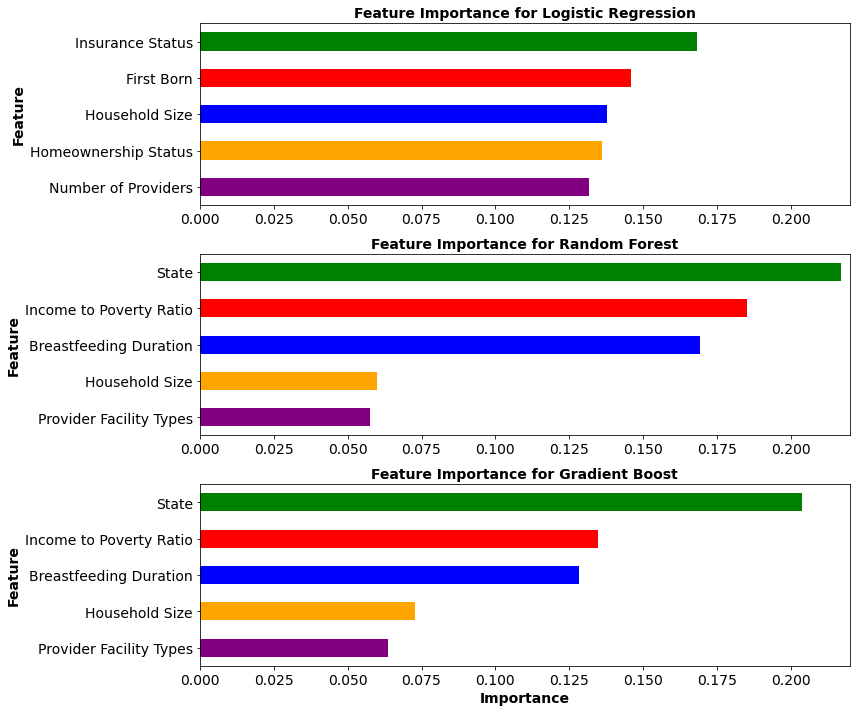

In [80]:
fig, ((axis1, axis2, axis3)) = plt.subplots(3, 1, figsize=(12, 10))

lr_clfs_underspld_df[-5:].plot('Feature name', 'Importance', kind='barh', legend=False, color=['purple', 'orange', 'blue', 'red', 'green'], ax=axis1)
rf_clfs_underspld_df[-5:].plot('Feature name', 'Importance', kind='barh', legend=False, color=['purple', 'orange', 'blue', 'red', 'green'], ax=axis2)
lgbm_clfs_underspld_df[-5:].plot('Feature name', 'Importance', kind='barh', legend=False, color=['purple', 'orange', 'blue', 'red', 'green'], ax=axis3)

labels1 = [item.get_text() for item in axis1.get_yticklabels()]
labels1[4] = 'Insurance Status'
labels1[3] = 'First Born'
labels1[2] = 'Household Size'
labels1[1] = 'Homeownership Status'
labels1[0] = 'Number of Providers'

labels2 = [item.get_text() for item in axis2.get_yticklabels()]
labels2[4] = 'State'
labels2[3] = 'Income to Poverty Ratio' 
labels2[2] = 'Breastfeeding Duration'
labels2[1] = 'Household Size' 
labels2[0] = 'Provider Facility Types' 

labels3 = [item.get_text() for item in axis3.get_yticklabels()]
labels3[4] = 'State'
labels3[3] = 'Income to Poverty Ratio' 
labels3[2] = 'Breastfeeding Duration'
labels3[1] = 'Household Size' 
labels3[0] = 'Provider Facility Types' 

axis1.set_yticklabels(labels1)
axis2.set_yticklabels(labels2)
axis3.set_yticklabels(labels3)

for i, ax in enumerate([axis1, axis2, axis3]):
    ax.set_xlim([0, .22])
    # ax.set_xlabel('Importance', fontsize = 14, fontweight= 'bold')
    ax.set_ylabel('Feature', fontsize = 14, fontweight= 'bold')
    ax.tick_params(axis='both', which='major', labelsize=14)

axis3.set_xlabel('Importance', fontsize = 14, fontweight= 'bold')

axis1.set_title('Feature Importance for Logistic Regression', fontsize=14, fontweight= 'bold')
axis2.set_title('Feature Importance for Random Forest', fontsize=14, fontweight= 'bold')
axis3.set_title('Feature Importance for Gradient Boost', fontsize=14, fontweight= 'bold')

plt.tight_layout()
plt.show()


### 7- Conclusion and future research
In this project, I've applied machine learning models to predict vaccination status for children aged 19 through 35 months in the US. In the first part of the project, I applied Logistic Regression, KNN, Random Forest and Light Gradient Boosting Machine on the training set and got very disappointing specificity values, despite good f1-score (90%). This was likely due to the highly imbalanced class. 

In order to improve my models, I performed some oversampling and undersampling techniques and the Random Undersampling technique was my preferred choice. Logistic Regression and Gradient Boost performed the best with highest f1-score (72%) and specificity (57%), acceptable accuracy (61%). They both offered the best trade-off between f1-score and specificity. Socio-economic and geographic features were very important to identify the characteristics of the families of these unvaccinated children. These features can help health officials and physicians address undecided parents about vaccines to hopefully sway them and design vaccination-promotion policies.

As future work, feature engineering and/or gathering external sources can probably improve the model. For example, how often and what types of website (social media platforms, blogs, reviews) do parents visit to get their information about vaccines.

